In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
from calendar import month_abbr
from calendar import month_name
import scipy.stats as stats
import math
import geopandas as gp
import pandas as pd

In [2]:
from dask.distributed import Client  
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 251.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43221,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.20 GiB
Comm: tcp://127.0.0.1:36947,Total threads: 4
Dashboard: /proxy/46303/status,Memory: 35.89 GiB
Nanny: tcp://127.0.0.1:45053,


In [208]:
statefile = '/home/156/ah3693/CLEX_summer/STE_2021_AUST_SHP_GDA2020.zip'
states = gp.read_file('zip://'+statefile)

In [4]:
# dp_obs_new = xr.open_dataset('/scratch/w97/ast561/agcd_v1_precip_total_r005_monthly_190001-202208_regridded025.nc')

dp_obs_new = xr.open_dataset('/g/data/w97/zg0866/ForAshley/AGCD/agcd_v2_precip_total_r005_monthly_1900-2023.nc').drop_duplicates('time')
fname = '/g/data/w97/zg0866/ForAshley/land_fixed_0.05.nc'
f = nc.Dataset(fname)
mask = f.variables['land'][:]
precip_masked = dp_obs_new.precip.where(mask==1)
precip = precip_masked

In [6]:
gb = precip.groupby('time.month')
precip_anom = gb - gb.mean(dim='time')

In [8]:
lat = precip.lat
lon = precip.lon

In [11]:
# Plot Precipitation anomaly at specific month and year
def precip_plot(year,month):
    index = y.index(year)+1
    ax = fig.add_subplot(2,4,index,projection=ccrs.PlateCarree(central_longitude=180))
    ax.set_title('Precipitation Anomaly of {}'.format(year))
    plt.pcolormesh(lon,lat,pre_anom[(month-1)+(year-1950)*12,:,:],transform=ccrs.PlateCarree(),cmap='RdBu',vmin=-100,vmax=100)
    plt.colorbar(ax=ax, orientation='vertical')
    ax.coastlines()

## Identify El Nino and La Nina 
(Nov, Dec, Jan, Feb continuous signal => count as an ENSO year)
### El Nino:
Single: 1951, 1953, 1963, 1965, 1972, 1979, 1982, 1991, 1994, 1997, 2002, 2004, 2006, 2009, 2018

Double: 1957-1958, 1968-1969, 1976-1977, 1986-1987, 2014-2015

Triple:

### La Nina:
Single: 1964, 1988, 1995, 2005

Double: 1954-1955,1970-1971, 1983-1984, 2007-2008, 2010-2011, 2016-2017

Triple: 1973-1975, 1998-2000

### Xarray method

In [12]:
ds_obs = xr.open_dataset('/g/data/w97/ah3693-2/CLEX_summer/sst.mnmean.nc')
sst_nino34 = ds_obs.where((ds_obs.lat<=5) & (ds_obs.lat>=-5) & (ds_obs.lon>=190) & (ds_obs.lon<=240), drop=True)
# sst_nino34 = ds_obs.sel(lat=slice(4,-4),lon=slice(190,240))
# & (ds_obs['time.year']>=1900) & (ds_obs['time.year']<=2023)

In [29]:
# NOAA exactly same method

weights = np.cos(np.deg2rad(sst_nino34.sst.lat))
weights.name = "weights"

sst_weighted = sst_nino34.sst.weighted(weights)
weighted_mean = sst_weighted.mean(dim=['lat','lon'])

def anom(df,time_period,base_year):
    gb = df.sel(time=time_period).groupby('time.month')
    gb_base = df.sel(time=base_year).groupby('time.month')
    df_anom = gb - gb_base.mean(dim='time')
    return df_anom

anomalies = []

# 1900-2010
for year in range(1896,2011,5):
    time_period = slice(str(year),str(year+4))
    base_year = slice(str(year-15),str(year+14))
    
    anomaly = anom(weighted_mean,time_period,base_year)
    anomalies.append(anomaly)

# 2011-2023
anomaly = anom(weighted_mean, slice(str(2011),str(2023)), slice(str(1991),str(2020)))
anomalies.append(anomaly)

# Concatenate the anomalies along the time dimension
all_anomalies = xr.concat(anomalies, dim='time')

# index = mean sst over the whole region
detrended_nino34 = all_anomalies.rolling(time = 3,center=True).mean().dropna(dim='time').sel(time=slice('1900','2023'))

index_nino34 = detrended_nino34.round(1)

In [30]:
# Set the threshold value
threshold = 0.5

# Create a mask for values greater than the threshold
mask_EN = (index_nino34 >= threshold) 
mask_LN = (index_nino34 <= -threshold)

# Find the consecutive months with the threshold condition
consecutive_months_EN = mask_EN.rolling(time=5, min_periods=5).sum() >= 5
consecutive_months_LN = mask_LN.rolling(time=5, min_periods=5).sum() >= 5

# Select the months that meet both the threshold and consecutive months condition
selected_index_EN = index_nino34.where(consecutive_months_EN).dropna(dim='time')
selected_index_LN = index_nino34.where(consecutive_months_LN).dropna(dim='time')

elnino_y = selected_index_EN.sel(time = selected_index_EN.time.dt.month.isin([12]))
elnino_y2 = selected_index_EN.sel(time = selected_index_EN.time.dt.month.isin([1,2,3,4]))
lanina_y = selected_index_LN.sel(time = selected_index_LN.time.dt.month.isin([12]))
lanina_y2 = selected_index_LN.sel(time = selected_index_LN.time.dt.month.isin([1,2,3,4]))

elnino_year = np.sort(list(set(np.append(elnino_y.time.dt.year.values,elnino_y2.time.dt.year.values-1))))
lanina_year = np.sort(list(set(np.append(lanina_y.time.dt.year.values,lanina_y2.time.dt.year.values-1))))

print(elnino_year)
print(lanina_year)
print(len(elnino_year),len(lanina_year))

[1902 1904 1905 1911 1913 1914 1918 1919 1923 1925 1930 1939 1940 1941
 1951 1953 1957 1958 1963 1965 1968 1969 1972 1976 1977 1979 1982 1986
 1987 1991 1994 1997 2002 2004 2006 2009 2014 2015 2018]
[1903 1906 1908 1909 1910 1915 1916 1917 1922 1924 1933 1938 1942 1949
 1954 1955 1964 1970 1971 1973 1974 1975 1983 1984 1988 1995 1998 1999
 2000 2005 2007 2008 2010 2011 2016 2017 2020 2021 2022]
39 39


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


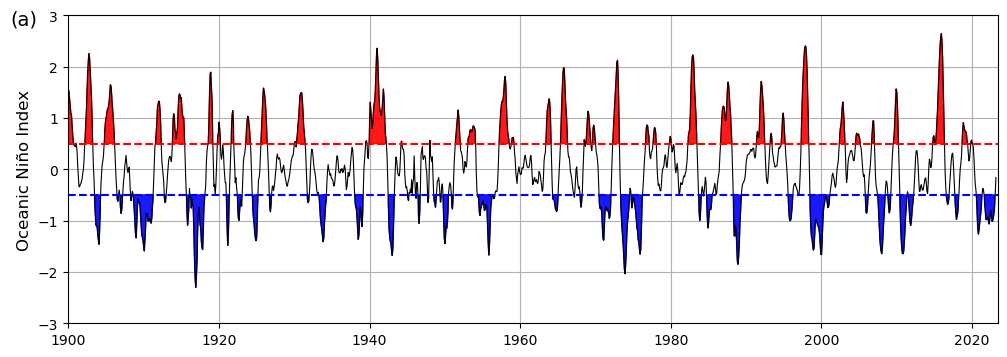

In [31]:
fig, ax = plt.subplots(figsize=(12, 4))
plt.plot(detrended_nino34.time.values,detrended_nino34,color='black',linewidth=0.8)

# Filter positive and negative values
positive_values = detrended_nino34.where(detrended_nino34 > 0)
negative_values = detrended_nino34.where(detrended_nino34 < 0)

# Fill the area between the positive values and the positive dashed line
ax.fill_between(positive_values.time.values, positive_values.where(positive_values > 0.5).values, 0.5, color='red', interpolate=True, alpha=0.9)

# Fill the area between the negative values and the negative dashed line
ax.fill_between(negative_values.time.values, negative_values.where(negative_values < -0.5).values, -0.5, color='blue', interpolate=True, alpha=0.9)
    
ax.axhline(0.5,ls='--',c='red')
ax.axhline(-0.5,ls='--',c='blue')
plt.ylabel('Oceanic Niño Index',fontsize=12)
plt.xlim((-25600,19500))
plt.xticks(rotation='horizontal')
plt.ylim((-3,3))
ax.grid()
ax.set_axisbelow(True)


ax.text(-0.062, 1.02, "(a)", transform=ax.transAxes, fontsize=14, va='top')

plt.savefig('/home/156/ah3693/CLEX_summer/Fig1_Oceanic_Nino_Index.eps', format='eps',bbox_inches="tight",dpi=700)

plt.show()

In [32]:
# Seasonal Average of El Nino and La Nina years

def ENSO_season(ENSO_year):
    
    precip_year1 = precip_anom.sel(time=precip_anom.time.dt.year.isin([ENSO_year]))
    precip_year2 = precip_anom.sel(time=precip_anom.time.dt.year.isin([np.asarray(ENSO_year) + 1]))
    precip_jja = precip_year1.sel(time=precip_year1.time.month.isin([6,7,8]))
    precip_son = precip_year1.sel(time=precip_year1.time.month.isin([9,10,11]))
    precip_djf = xr.concat([precip_year1.sel(time=precip_year1.time.month.isin([12])),precip_year2.sel(time=precip_year2.time.month.isin([1,2]))],dim='time')
    precip_mam = precip_year2.sel(time=precip_year2.time.month.isin([3,4,5]))
    
    return precip_jja,precip_son,precip_djf,precip_mam

ENSO_season_mean = [[],[]] # EN_,LN_,
for i,year in enumerate((elnino_year,lanina_year)):
    ENSO_season_mean[i] = ENSO_season(year)

In [33]:
# pvalue = [[[],[],[],[]],[[],[],[],[]]]

# for i in range(2):
#     for j in range(4):
#         pvalue[i][j] = stats.ttest_1samp(ENSO_season_mean[i][j],0,axis=0)[1]

# np.save('/g/data/w97/ah3693-2/CLEX_summer/FigS2_pvalue_new.npy', pvalue)


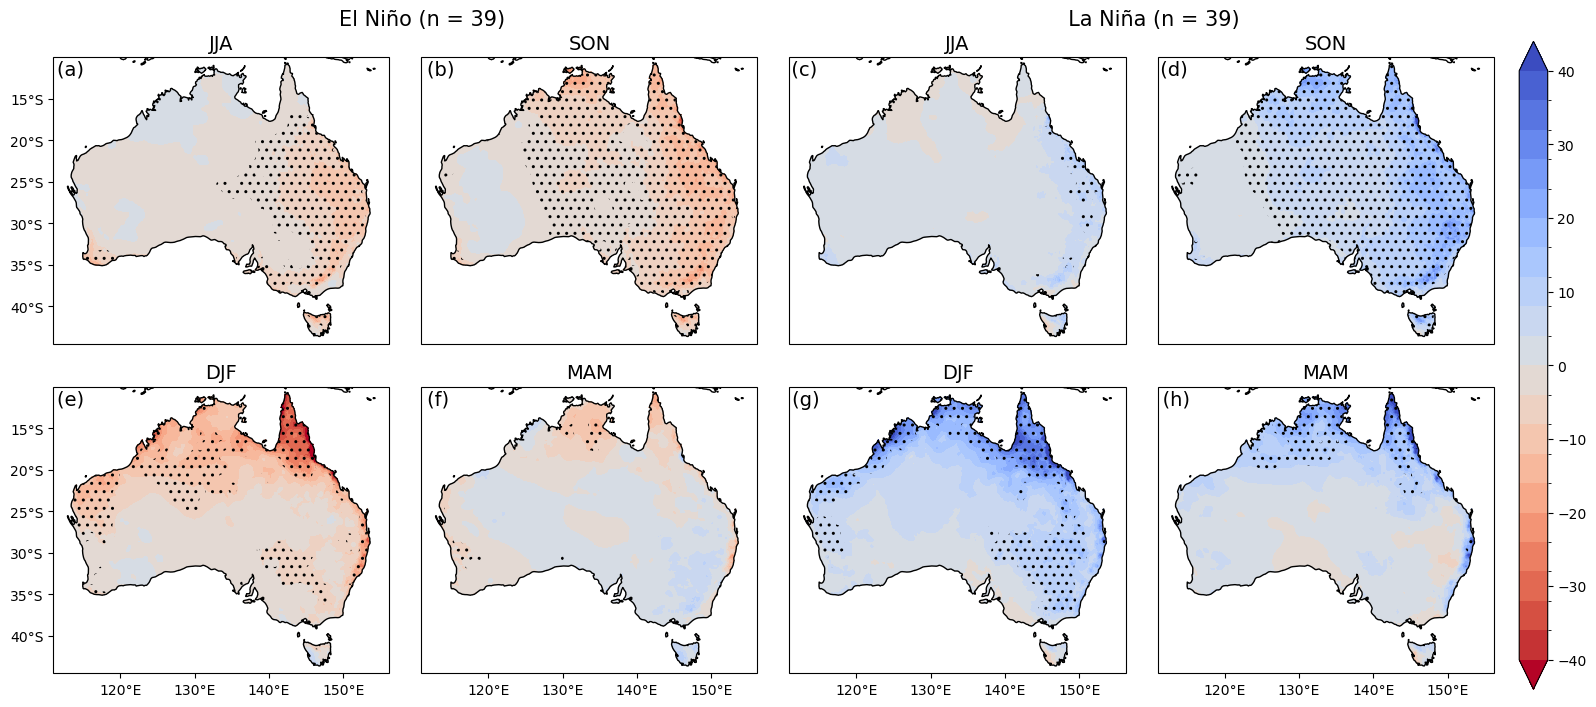

In [34]:

pvalue = np.load('/g/data/w97/ah3693-2/CLEX_summer/FigS2_pvalue_new.npy')

fig, axes = plt.subplots(2,4, figsize=(19,8),subplot_kw=dict(projection=ccrs.PlateCarree()))

title = ['JJA','SON','DJF','MAM']

for i in range(2):    
    for j in range(4):
        ax=axes[int(np.floor(j/2)),int(j%2+i*2)]
        p = ENSO_season_mean[i][j].mean(dim='time').plot.contourf(ax=ax,transform=ccrs.PlateCarree(),cmap='coolwarm_r',levels=np.linspace(-40,40,21),extend='both',add_colorbar=False)
        ax.contourf(precip.lon, precip.lat, pvalue[i][j], levels = [0,0.05], hatches=['..'], colors='none', alpha=0.0)
        ax.set_title(title[j],fontsize=14)
        
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        ax.coastlines()
        states.boundary.plot(ax=ax, color='black', linewidth=0.0)
        ax.set_extent([111,156.2, -44.5, -10.], crs=ccrs.PlateCarree())

for i in range(4):
    axes[1,i].set_xticks([120,130,140,150], crs=ccrs.PlateCarree())
    axes[1,i].set_xticklabels(['120°E','130°E','140°E','150°E'])
    axes[1,i].set_xlabel('')
for j in range(2):    
    axes[j,0].set_yticks([-40,-35,-30,-25,-20,-15], crs=ccrs.PlateCarree())
    axes[j,0].set_yticklabels(['40°S','35°S','30°S','25°S','20°S','15°S'])
    axes[j,0].set_ylabel('')

cax = plt.axes([0.905, 0.09, 0.015, 0.81]) #[left, bottom, width, height]
plt.colorbar(p,cax=cax,orientation='vertical')
cax.set_yticks([-40,-30,-20,-10,0,10,20,30,40])

plt.text(-51.3,39.5,'(a)                                                        (b)                                                       (c)                                                        (d)',fontsize=14)
plt.text(-51.3,-5.5,'(e)                                                        (f)                                                        (g)                                                        (h)',fontsize=14)

plt.subplots_adjust(wspace=0,hspace=0.15)
plt.suptitle('El Niño (n = 39)                                                                                     La Niña (n = 39)',x=0.521,y=0.94,fontsize=15)
# plt.title('(a)                                                                                (b)                                                                                (c)                                                                                (d)',x=-51.5,y=1.01,fontsize=12,loc='left')


plt.savefig('/home/156/ah3693/CLEX_summer/FigS2_seasonal_rainfall_anomaly_composites.eps',bbox_inches="tight", format='eps',dpi=700)

plt.show()

In [35]:
fst_elnino_f = [1902, 1904, 1911, 1913, 1918, 1923, 1925, 1930, 1939, 1951, 1953, 1957, 1963, 1965, 1968, 1972, 1976, 1979, 1982, 1986, 1991, 1994, 1997, 2002, 2004, 2006, 2009, 2014, 2018]
fst_elnino_s = [1905, 1914, 1919, 1940, 1958, 1969, 1977, 1987, 2015]
fst_lanina_f = [1903, 1906, 1908, 1915, 1922, 1924, 1933, 1938, 1942, 1949, 1954, 1964, 1970, 1973, 1983, 1988, 1995, 1998, 2005, 2007, 2010, 2016, 2020]
fst_lanina_s = [1909, 1916, 1955, 1971, 1974, 1984, 1999, 2008, 2011, 2017, 2021]
fst_lanina_t = [1910, 1917, 1975, 2000, 2022]

In [36]:
def ENSO_ndj(ENSO_year):
    
    precip_year1 = precip_anom.sel(time=precip_anom.time.dt.year.isin([ENSO_year]))
    precip_year2 = precip_anom.sel(time=precip_anom.time.dt.year.isin([np.asarray(ENSO_year) + 1]))
    precip_n = precip_year1.sel(time=precip_year1.time.month.isin([11]))
    precip_d = precip_year1.sel(time=precip_year1.time.month.isin([12]))
    precip_j = precip_year2.sel(time=precip_year2.time.month.isin([1]))
    
    return precip_n,precip_d,precip_j

ENSO_fst = [[],[],[],[],[],[]] # EN_f,EN_s,LN_f,LN_s,LN_t
for i,year in enumerate((fst_elnino_f,fst_elnino_s,fst_lanina_f,fst_lanina_s,fst_lanina_t)):
    ENSO_fst[i] = ENSO_ndj(year)

In [37]:
# pvalue = [[[],[],[]],[[],[],[]],[[],[],[]],[[],[],[]],[[],[],[]]]

# for i in range(5):
#     for j in range(3):
#         pvalue[i][j] = stats.ttest_1samp(ENSO_fst[i][j],0,axis=0)[1]
        
# np.save('/g/data/w97/ah3693-2/CLEX_summer/Fig5_pvalue.npy', pvalue)

In [39]:
for sst_i in [fst_elnino_f,fst_elnino_s,fst_lanina_f,fst_lanina_s,fst_lanina_t]:
    print(len(sst_i))

29
9
23
11
5


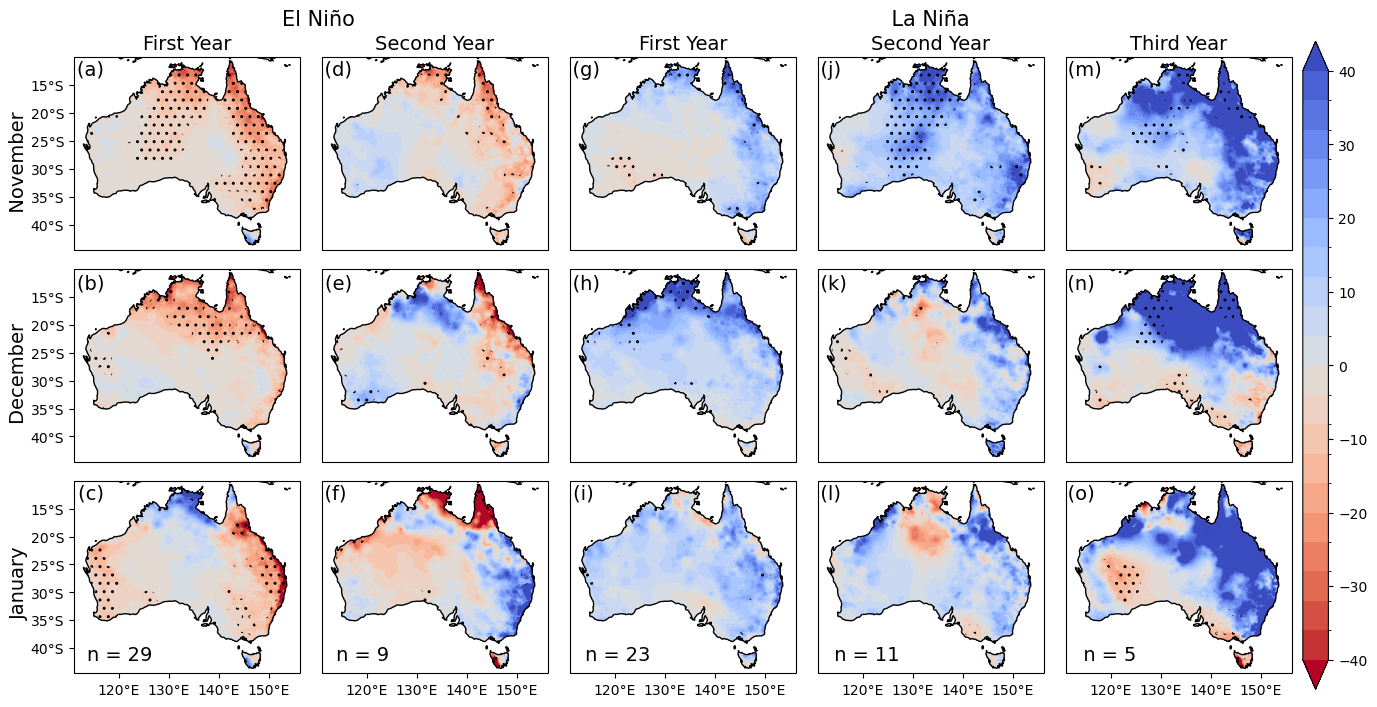

In [40]:
pvalue = np.load('/g/data/w97/ah3693-2/CLEX_summer/Fig5_pvalue.npy')

fig, axes = plt.subplots(3,5, figsize=(16,8),subplot_kw=dict(projection=ccrs.PlateCarree()))

title = ['First Year','Second Year','First Year','Second Year','Third Year']

for i in range(5):    
    for j in range(3):
        ax=axes[j,i]
        p = ENSO_fst[i][j].mean(dim='time').plot.contourf(ax=ax,transform=ccrs.PlateCarree(),cmap='coolwarm_r',levels=np.linspace(-40,40,21),extend='both',add_colorbar=False)
        ax.contourf(precip.lon, precip.lat, pvalue[i][j], levels = [0,0.05], hatches=['..'], colors='none', alpha=0.0)
        
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        ax.coastlines()
        states.boundary.plot(ax=ax, color='black', linewidth=0.0)
        ax.set_extent([111,156.2, -44.5, -10.], crs=ccrs.PlateCarree())
        

for i in range(5):
    axes[0,i].set_title(title[i],fontsize=14)
    axes[2,i].set_xticks([120,130,140,150], crs=ccrs.PlateCarree())
    axes[2,i].set_xticklabels(['120°E','130°E','140°E','150°E'])
    axes[2,i].set_xlabel('')
for j in range(3):    
    axes[j,0].set_yticks([-40,-35,-30,-25,-20,-15], crs=ccrs.PlateCarree())
    axes[j,0].set_yticklabels(['40°S','35°S','30°S','25°S','20°S','15°S'])
    axes[j,0].set_ylabel('')

cax = plt.axes([0.9, 0.09, 0.016, 0.81]) #[left, bottom, width, height]
plt.colorbar(p,cax=cax,orientation='vertical')
cax.set_yticks([-40,-30,-20,-10,0,10,20,30,40])

plt.text(-50.5,-34,'January                    December                  November',rotation=90,fontsize=14)
# plt.text(-45,70,'                     El Niño                                                                                       La Niña',rotation=0,fontsize=15)
# plt.text(-48,42,'(a)                                                        (d)                                                        (g)                                                       (j)                                                         (m)')
# plt.title(' (a)                                       (d)                                        (g)                                       (j)                                                     (m)',x=-47.9,y=1.01,fontsize=14,loc='left')
plt.text(-47.9,39.4,'(a)                                    (d)                                    (g)                                    (j)                                     (m)',fontsize=14)
plt.text(-47.9,10.4,'(b)                                    (e)                                    (h)                                    (k)                                    (n)',fontsize=14)
plt.text(-48.07,-18.1,' (c)                                    (f)                                     (i)                                     (l)                                     (o)',fontsize=14)

plt.text(-47.5,-40,'n = 29                              n = 9                                n = 23                              n = 11                              n = 5',fontsize=14)

plt.subplots_adjust(wspace=0,hspace=0.1)
plt.suptitle('El Niño                                                                                 La Niña',x=0.477,y=0.94,fontsize=15)

plt.savefig('/home/156/ah3693/CLEX_summer/Fig4_Summer_Rainfall_Anomalies.eps',bbox_inches="tight", format='eps',dpi=700)

plt.show()

In [41]:
def ENSO_allmonth(ENSO_year):
    
    precip_year1 = precip_anom.sel(time=precip_anom.time.dt.year.isin([ENSO_year]))
    precip_year2 = precip_anom.sel(time=precip_anom.time.dt.year.isin([np.asarray(ENSO_year) + 1]))
    precip_jun_to_dec = [precip_year1.sel(time=precip_year1.time.month.isin([month])) for month in range(6,13)]
    precip_jan_to_may = [precip_year2.sel(time=precip_year2.time.month.isin([month])) for month in range(1,6)]
    
    return precip_jun_to_dec,precip_jan_to_may

ENSO_fst_all = [[],[],[],[],[]] # EN_f,EN_s,LN_f,LN_s,LN_t
for i,year in enumerate((fst_elnino_f,fst_elnino_s,fst_lanina_f,fst_lanina_s,fst_lanina_t)):
    ENSO_fst_all[i] = ENSO_allmonth(year)

In [43]:
# pvalue = [[[[],[],[],[],[],[],[]],[[],[],[],[],[]]],[[[],[],[],[],[],[],[]],[[],[],[],[],[]]],[[[],[],[],[],[],[],[]],[[],[],[],[],[]]],[[[],[],[],[],[],[],[]],[[],[],[],[],[]]],[[[],[],[],[],[],[],[]],[[],[],[],[],[]]]]

# for i in range(5):
#     for j in range(12):
#         if j <= 6:
#             k = 0
#         else:
#             k = 1
#             j = j - 7
#         pvalue[i][k][j] = stats.ttest_1samp(ENSO_fst_all[i][k][j],0,axis=0)[1]
        
# np.save('/g/data/w97/ah3693-2/CLEX_summer/FigS3_pvalue.npy', pvalue)

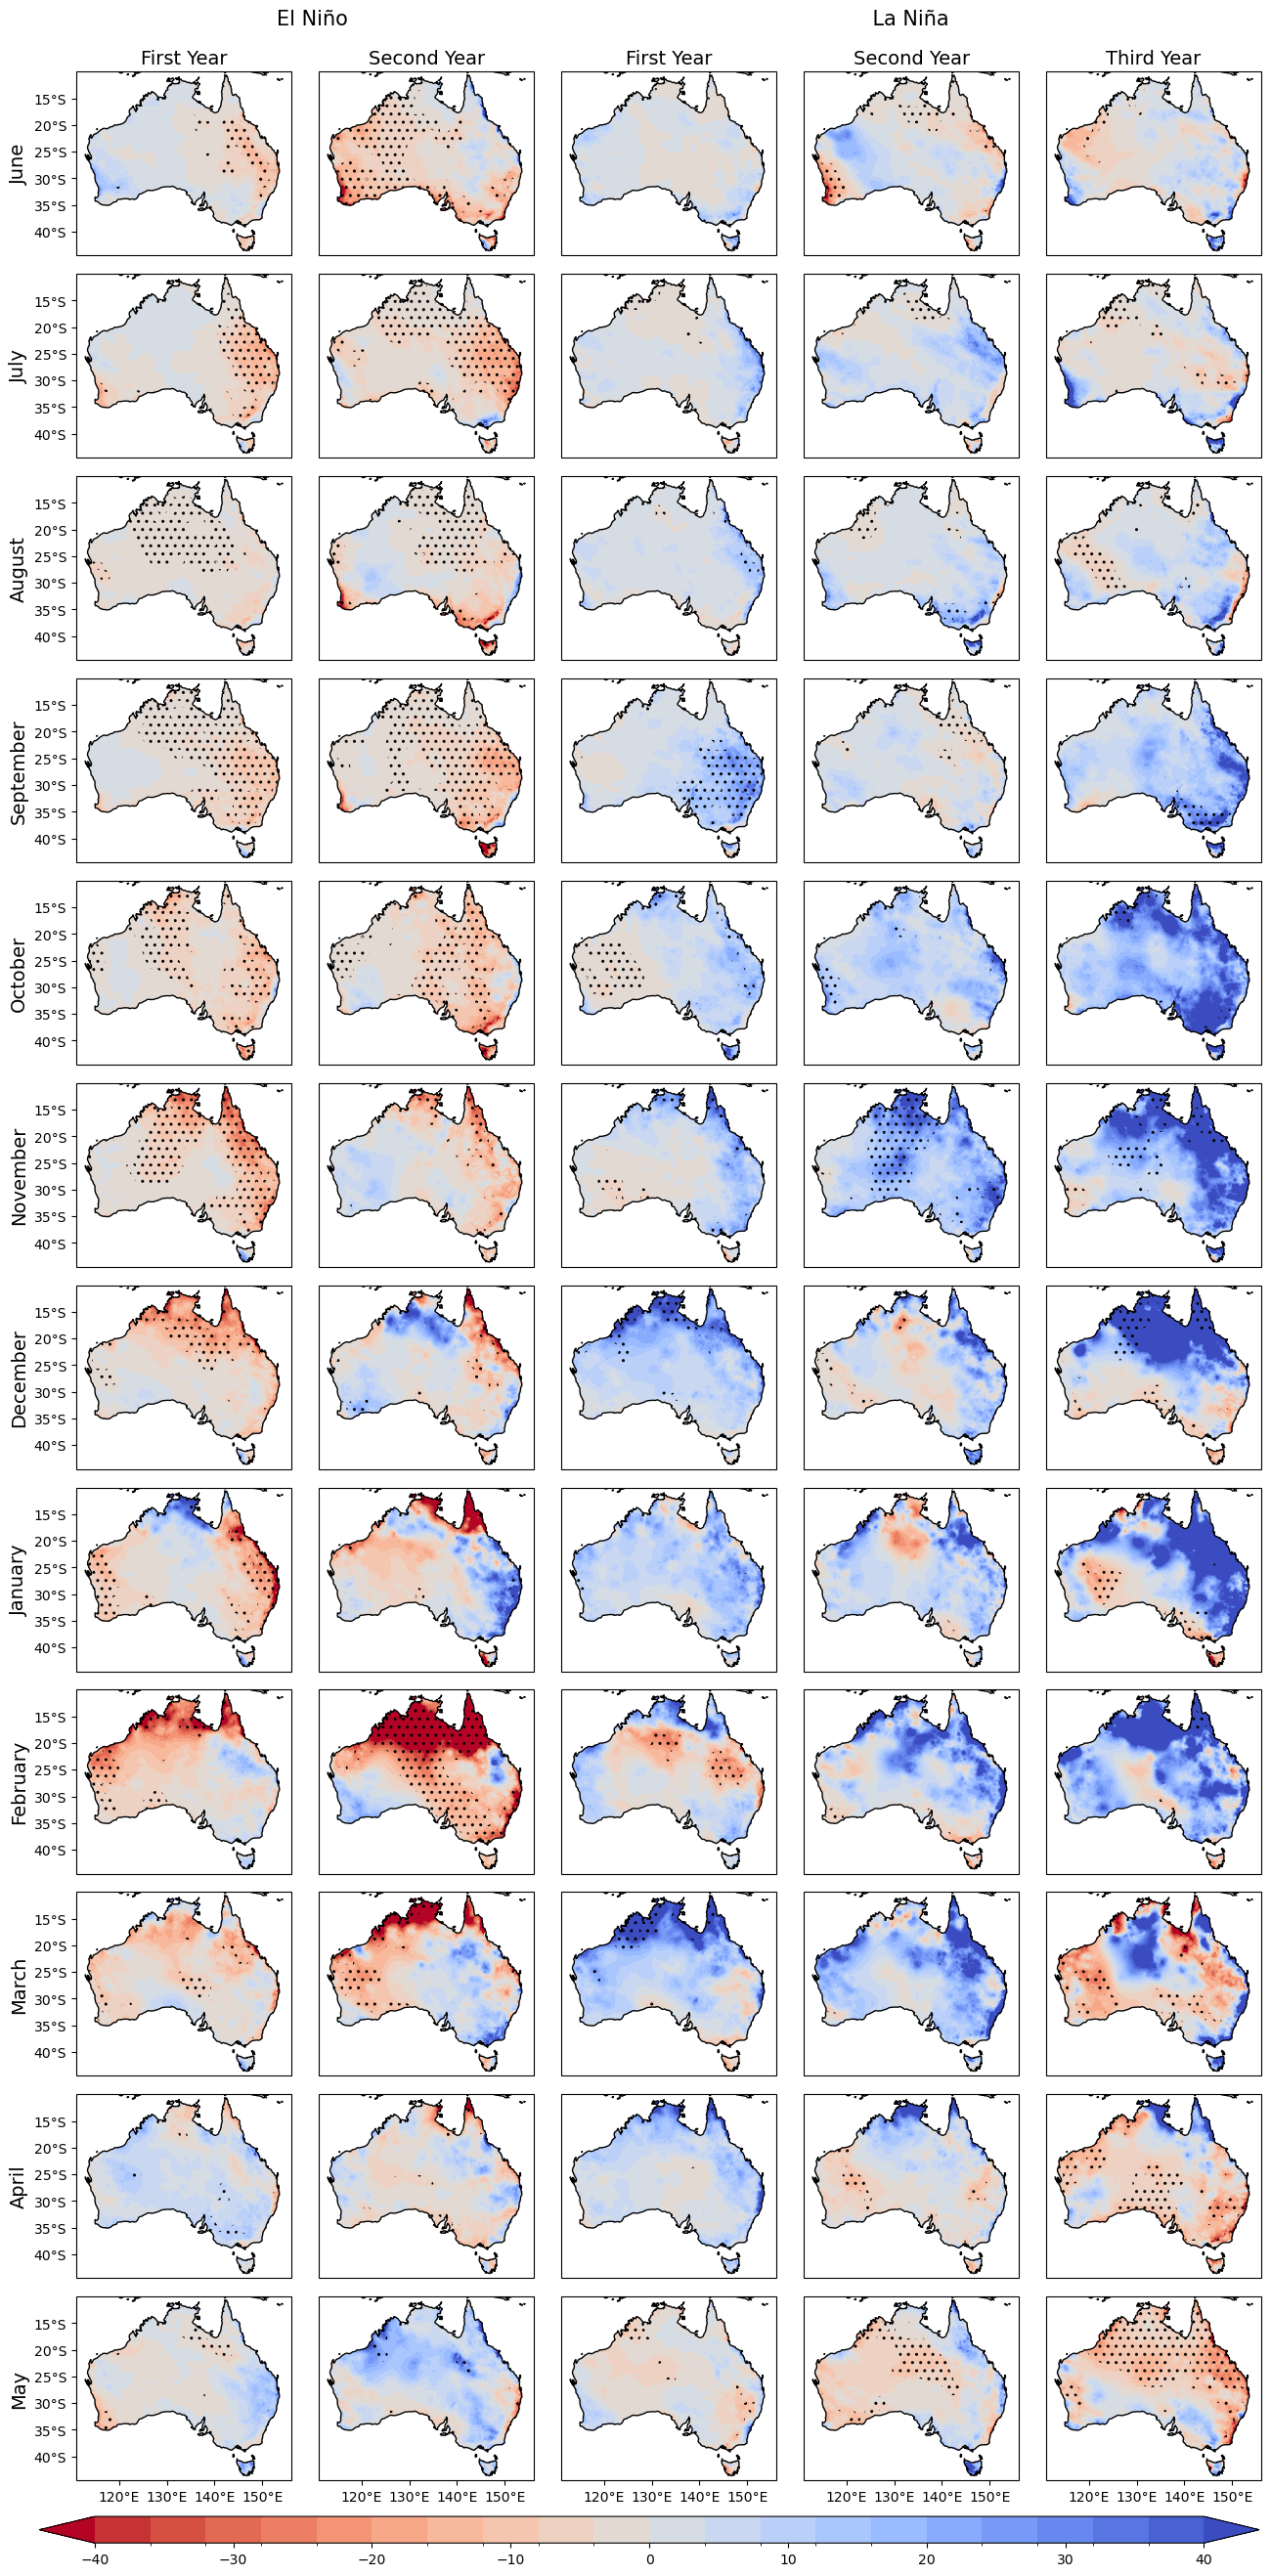

In [125]:
pvalue = np.load('/g/data/w97/ah3693-2/CLEX_summer/FigS3_pvalue.npy',allow_pickle=True)
year_name = month_name[6:]+month_name[1:6]

fig, axes = plt.subplots(12,5, figsize=(16,32),subplot_kw=dict(projection=ccrs.PlateCarree()))

title = ['First Year','Second Year','First Year','Second Year','Third Year']

for i in range(5):    
    for j in range(12):
        ax=axes[j,i]
        if j <= 6:
            k = 0
        else:
            k = 1
            j = j - 7
        p = ENSO_fst_all[i][k][j].mean(dim='time').plot.contourf(ax=ax,transform=ccrs.PlateCarree(),cmap='coolwarm_r',levels=np.linspace(-40,40,21),extend='both',add_colorbar=False)
        ax.contourf(precip.lon, precip.lat, pvalue[i][k][j], levels = [0,0.05], hatches=['..'], colors='none', alpha=0.0)
        
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        ax.coastlines()
        states.boundary.plot(ax=ax, color='black', linewidth=0.0)
        ax.set_extent([111,156.2, -44.5, -10.], crs=ccrs.PlateCarree())
        

for i in range(5):
    axes[0,i].set_title(title[i],fontsize=14)
    axes[11,i].set_xticks([120,130,140,150], crs=ccrs.PlateCarree())
    axes[11,i].set_xticklabels(['120°E','130°E','140°E','150°E'])
    axes[11,i].set_xlabel('')
for j in range(12):    
    axes[j,0].set_yticks([-40,-35,-30,-25,-20,-15], crs=ccrs.PlateCarree())
    axes[j,0].set_yticklabels(['40°S','35°S','30°S','25°S','20°S','15°S'])
    axes[j,0].set_ylabel(year_name[j],fontsize=14)

cax = plt.axes([0.11, 0.09, 0.78, 0.0085]) #[left, bottom, width, height]
plt.colorbar(p,cax=cax,orientation='horizontal')
cax.set_xticks([-40,-30,-20,-10,0,10,20,30,40])

# plt.text(-50.5,-34,'January                    December                  November',rotation=90,fontsize=14)
# plt.text(-47.9,39.4,'(a)                                    (d)                                    (g)                                    (j)                                     (m)',fontsize=14)
# plt.text(-47.9,10.4,'(b)                                    (e)                                    (h)                                    (k)                                    (n)',fontsize=14)
# plt.text(-48.07,-18.1,' (c)                                    (f)                                     (i)                                     (l)                                     (o)',fontsize=14)

# plt.text(-47.5,-40,'n = 29                              n = 9                                n = 23                              n = 11                              n = 5',fontsize=14)

plt.subplots_adjust(wspace=0,hspace=0.1)
plt.suptitle('El Niño                                                                                 La Niña',x=0.477,y=0.90,fontsize=15)

plt.savefig('/home/156/ah3693/CLEX_summer/FigS3_Rainfall_Anomaly_Composites.eps',bbox_inches="tight", format='eps',dpi=700)

plt.show()

In [126]:
# Correlation coefficient using xarray

def season_time_series(df):
    df_s = df.resample(time='QS-DEC').mean(dim='time')

    df_jja = df_s.sel(time=df_s.time.dt.month.isin([6]))
    df_son = df_s.sel(time=df_s.time.dt.month.isin([9]))
    df_djf = df_s.sel(time=df_s.time.dt.month.isin([12]))
    df_mam = df_s.sel(time=df_s.time.dt.month.isin([3]))
    
    return df_jja,df_son,df_djf,df_mam

precip_season = season_time_series(precip_anom)
nino_season = season_time_series(detrended_nino34)

In [127]:
# Concurrent correlation coefficient

def concurrent_corr(df,di):
    # df_mam_corr = xr.corr(df[0].sst,NRM_p_s[0],dim='time') if it is a dataset below is for dataarray (SST)
    df_jja_corr = xr.corr(df[0],di[0],dim='time')
    df_son_corr = xr.corr(df[1],di[1],dim='time')
    df_djf_corr = xr.corr(df[2],di[2],dim='time')
    df_mam_corr = xr.corr(df[3],di[3],dim='time')
    return df_jja_corr,df_son_corr,df_djf_corr,df_mam_corr

ENSO_corr_concur = concurrent_corr(precip_season,nino_season)

In [128]:
# Lagged correlation coefficient
nino34_ndj = detrended_nino34.sel(time = detrended_nino34.time.dt.month.isin([12]))

def lag_corr(df,nino34_ndj):
    nino34_ndj_r = nino34_ndj.reindex(time=df[0].sel(time=slice('1900','2022')).time, method='backfill')
    df_jja_corr = xr.corr(df[0].sel(time=slice('1900','2022')),nino34_ndj_r,dim='time')
        
    nino34_ndj_r = nino34_ndj.reindex(time=df[1].sel(time=slice('1900','2022')).time, method='nearest')
    df_son_corr = xr.corr(df[1].sel(time=slice('1900','2022')),nino34_ndj_r,dim='time')
        
    nino34_ndj_r = nino34_ndj.reindex(time=df[2].sel(time=slice('1900','2022')).time, method='nearest')
    df_djf_corr = xr.corr(df[2].sel(time=slice('1900','2022')),nino34_ndj_r,dim='time')
        
    nino34_ndj_r = nino34_ndj.reindex(time=df[3].sel(time=slice('1901','2023')).time, method='nearest')
    df_mam_corr = xr.corr(df[3].sel(time=slice('1901','2023')),nino34_ndj_r,dim='time')
    return df_jja_corr, df_son_corr, df_djf_corr, df_mam_corr

ENSO_corr = lag_corr(precip_season,nino34_ndj)

### Estimation of Australian Area

In [130]:
def one_grid_area(lat, lon):
    R = 6371.0  # Earth radius in kilometers
    lat_res = 0.05  # Grid resolution in degrees (latitude)
    lon_res = 0.05  # Grid resolution in degrees (longitude)

    # Calculate the width and height of the grid cell in kilometers
    dy = 2 * R * np.sin(np.deg2rad(lat_res / 2))
    dx = 2 * R * np.sin(np.deg2rad(lon_res / 2)) * np.cos(np.deg2rad(lat))

    # Calculate the area of the grid cell in square kilometers
    area = dy * dx

    return area

In [131]:
lat_i = np.where(mask==1)[0]
lon_i = np.where(mask==1)[1]
lat = precip_anom.lat
lon = precip_anom.lon

In [132]:
# grid_area = []

# for lat,lon in zip(lat[lat_i],lon[lon_i]):
#         grid = one_grid_area(lat,lon)
#         grid_area.append(grid)

# total_area = sum(grid_area)
# total_area.values
total_area = 7688792.22405556

### Percentage of Area for strongly correlated regions

In [133]:
def area(mask):
    lat = precip_anom.lat
    lon = precip_anom.lon
    lat_i = np.where(mask==True)[0]
    lon_i = np.where(mask==True)[1]


    grid_area = []

    for lat,lon in zip(lat[lat_i],lon[lon_i]):
            grid = one_grid_area(lat,lon)
            grid_area.append(grid)

    total_area = sum(grid_area)
    return total_area

In [134]:
# # ENSO_corr area
# area_mat = np.full((2, 4), 0)
# for i, thred in enumerate((-0.3, -0.4)):
#     for j in range(4):
#         area_mat[i, j] = area(soil_corr[j]<=thred)
    
    

In [135]:
# area_mat / np.array(total_area)

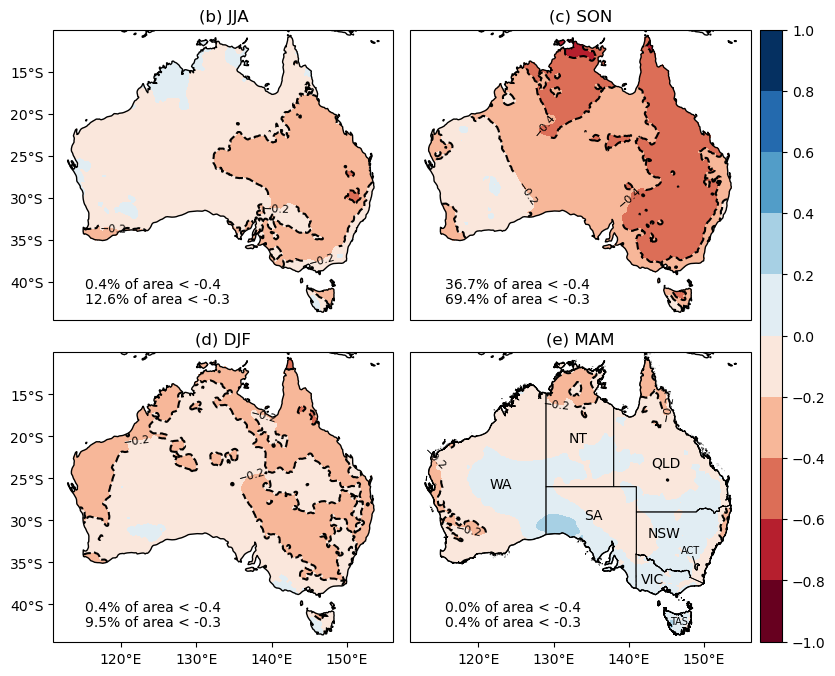

In [136]:
title = '(b) JJA','(c) SON','(d) DJF','(e) MAM'

fig, axes = plt.subplots(2,2, figsize=(9,8),subplot_kw=dict(projection=ccrs.PlateCarree()))

for i in range(4):
    ax=axes[int(np.floor(i/2)),int(i%2)]
    p = ENSO_corr[i].plot.contourf(ax=ax,transform=ccrs.PlateCarree(),cmap='RdBu',levels=np.linspace(-1,1,11),add_colorbar=False)
    contours = ENSO_corr[i].plot.contour(ax=ax,transform=ccrs.PlateCarree(),cmap='black',linestyles = '--',levels=[-0.2,-0.4,-0.6],add_colorbar=False)
    states.boundary.plot(ax=ax, color='black', linewidth=0.0)
    ax.set_extent([111,156.2, -44.5, -10.], crs=ccrs.PlateCarree())
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.coastlines()
    ax.set_title(title[i])
    plt.clabel(contours, inline=True, fontsize=8)
    # ax.axvline(138)
    # ax.axhline(-39)

states.boundary.plot(ax=axes[1,1], color='black', linewidth=0.6)
axes[0,0].set_yticks([-40,-35,-30,-25,-20,-15], crs=ccrs.PlateCarree())
axes[1,0].set_yticks([-40,-35,-30,-25,-20,-15], crs=ccrs.PlateCarree())
axes[1,0].set_xticks([120,130,140,150], crs=ccrs.PlateCarree())
axes[1,1].set_xticks([120,130,140,150], crs=ccrs.PlateCarree())
axes[0,0].set_yticklabels(['40°S','35°S','30°S','25°S','20°S','15°S'])
axes[1,0].set_yticklabels(['40°S','35°S','30°S','25°S','20°S','15°S'])
axes[1,0].set_xticklabels(['120°E','130°E','140°E','150°E'])
axes[1,1].set_xticklabels(['120°E','130°E','140°E','150°E'])
axes[0,0].set_ylabel('')
axes[1,0].set_ylabel('')
axes[1,0].set_xlabel('')
axes[1,1].set_xlabel('')

cax = plt.axes([0.91, 0.113, 0.025, 0.765]) #[left, bottom, width, height]
plt.colorbar(p,cax=cax,orientation='vertical')
cax.set_yticks([-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1])

plt.text(-30,0.155,'0.4% of area < -0.4',fontsize=10,color='k')
plt.text(-14,0.155,'36.7% of area < -0.4',fontsize=10,color='k')
plt.text(-30,-0.9,'0.4% of area < -0.4',fontsize=10,color='k')
plt.text(-14,-0.9,'0.0% of area < -0.4',fontsize=10,color='k')

plt.text(-30,0.105,'12.6% of area < -0.3',fontsize=10,color='k')
plt.text(-14,0.105,'69.4% of area < -0.3',fontsize=10,color='k')
plt.text(-30,-0.95,'9.5% of area < -0.3',fontsize=10,color='k')
plt.text(-14,-0.95,'0.4% of area < -0.3',fontsize=10,color='k')

plt.text(-12,-0.5,'WA')
plt.text(-8.5,-0.35,'NT')
plt.text(-4.8,-0.43,'QLD')
plt.text(-5,-0.66,'NSW')
plt.text(-3.5,-0.71,'ACT',fontsize = 7)
plt.text(-3,-0.75,'\ ')
plt.text(-5.3,-0.81,'VIC')
plt.text(-7.8,-0.6,'SA')
plt.text(-4,-0.945,'TAS',fontsize = 7)

plt.subplots_adjust(wspace=0.05,hspace=0.1)

plt.savefig('/home/156/ah3693/CLEX_summer/Fig1_ENSO_Australian_Rainfall_Relationship.eps', format='eps',bbox_inches="tight",dpi=700)

plt.show()

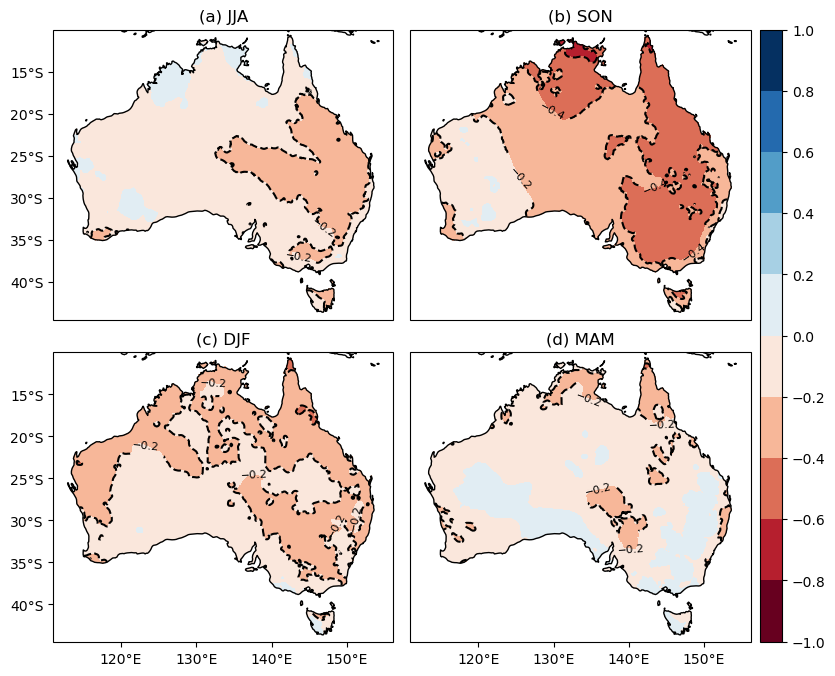

In [138]:
# Concurrent correlation plot
title = '(a) JJA','(b) SON','(c) DJF','(d) MAM'

fig, axes = plt.subplots(2,2, figsize=(9,8),subplot_kw=dict(projection=ccrs.PlateCarree()))

for i in range(4):
    ax=axes[int(np.floor(i/2)),int(i%2)]
    p = ENSO_corr_concur[i].plot.contourf(ax=ax,transform=ccrs.PlateCarree(),cmap='RdBu',levels=np.linspace(-1,1,11),add_colorbar=False)
    contours = ENSO_corr_concur[i].plot.contour(ax=ax,transform=ccrs.PlateCarree(),linestyles = '--',cmap='black',levels=[-0.2,-0.4,-0.6],add_colorbar=False)
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.coastlines()
    ax.set_title(title[i])
    plt.clabel(contours, inline=True, fontsize=8)
    states.boundary.plot(ax=ax, color='black', linewidth=0.0)
    ax.set_extent([111,156.2, -44.5, -10.], crs=ccrs.PlateCarree())

axes[0,0].set_yticks([-40,-35,-30,-25,-20,-15], crs=ccrs.PlateCarree())
axes[1,0].set_yticks([-40,-35,-30,-25,-20,-15], crs=ccrs.PlateCarree())
axes[1,0].set_xticks([120,130,140,150], crs=ccrs.PlateCarree())
axes[1,1].set_xticks([120,130,140,150], crs=ccrs.PlateCarree())
axes[0,0].set_yticklabels(['40°S','35°S','30°S','25°S','20°S','15°S'])
axes[1,0].set_yticklabels(['40°S','35°S','30°S','25°S','20°S','15°S'])
axes[1,0].set_xticklabels(['120°E','130°E','140°E','150°E'])
axes[1,1].set_xticklabels(['120°E','130°E','140°E','150°E'])
axes[0,0].set_ylabel('')
axes[1,0].set_ylabel('')
axes[1,0].set_xlabel('')
axes[1,1].set_xlabel('')

cax = plt.axes([0.91, 0.113, 0.025, 0.765]) #[left, bottom, width, height]
plt.colorbar(p,cax=cax,orientation='vertical')
cax.set_yticks([-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1])

plt.subplots_adjust(wspace=0.05,hspace=0.1)

plt.savefig('/home/156/ah3693/CLEX_summer/FigS1_Concurrent_ENSO_Australian_Rainfall_Relationship.eps', format='eps',bbox_inches="tight",dpi=700)

plt.show()

In [140]:
ENSO_corr[1].sel(lat=slice(-44,-10)).sel(lon=slice(112,154))
# .where(ENSO_corr[1]<-0.4,drop=True)

<xarray.DataArray (lat: 681, lon: 841)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lon      (lon) float32 112.0 112.1 112.1 112.2 ... 153.9 153.9 153.9 154.0
  * lat      (lat) float32 -44.0 -43.95 -43.9 -43.85 ... -10.1 -10.05 -10.0

In [206]:
# Precipication over affected region

#weighted
# weights_precip = np.cos(np.deg2rad(precip_anom.lat))
# weights_precip.name = "weights"

# precip_weighted = precip_anom.weighted(weights_precip)
# weighted_mean = precip_weighted.mean(dim=['lat','lon'])

affect_region_precip = precip_anom.where(ENSO_corr[1]<-0.4,drop=True).where(precip_anom.lon>=138).where(precip_anom.lat>=-39)
weights_precip = np.cos(np.deg2rad(affect_region_precip.lat))
weights_precip.name = "weights"

affect_region_precip_weighted = affect_region_precip.weighted(weights_precip)
affect_region_precip_mean = affect_region_precip_weighted.mean(dim=['lat','lon'])

In [143]:
year_1 = month_abbr[6:]+month_abbr[1:6]
year_2 = month_abbr[6:]+month_abbr[1:]+month_abbr[1:6]
year_3 = month_abbr[6:]+month_abbr[1:]+month_abbr[1:]+month_abbr[1:6]
nan3 = np.array([np.nan]*3)
nan5 = np.array([np.nan]*5)
nan12 = np.array([np.nan]*12)
nan24 = np.array([np.nan]*24)

In [150]:
# Precip 5 month running mean
# Running mean 5 months
affect_region_rolling_5 = affect_region_precip_mean.rolling(time=5,center=True).mean()
affect_region_rolling_5[0] = affect_region_precip_mean[0]
affect_region_rolling_5[1] = (affect_region_precip_mean[0]+affect_region_precip_mean[1])/2
affect_region_rolling_5[-2] = (affect_region_precip_mean[-2]+affect_region_precip_mean[-1])/2
affect_region_rolling_5[-1] = affect_region_precip_mean[-1]

rolling_5 = np.zeros((2,29,36))

# El Nino
rolling_5[0,0,:] = np.append(affect_region_rolling_5.sel(time=slice('1902-06','1903-05')),nan24)
rolling_5[0,1,:] = np.append(affect_region_rolling_5.sel(time=slice('1904-06','1906-05')),nan12)
rolling_5[0,2,:] = np.append(affect_region_rolling_5.sel(time=slice('1911-06','1912-05')),nan24)
rolling_5[0,3,:] = np.append(affect_region_rolling_5.sel(time=slice('1913-06','1915-05')),nan12)
rolling_5[0,4,:] = np.append(affect_region_rolling_5.sel(time=slice('1918-06','1920-05')),nan12)
rolling_5[0,5,:] = np.append(affect_region_rolling_5.sel(time=slice('1923-06','1924-05')),nan24)
rolling_5[0,6,:] = np.append(affect_region_rolling_5.sel(time=slice('1925-06','1926-05')),nan24)
rolling_5[0,7,:] = np.append(affect_region_rolling_5.sel(time=slice('1930-06','1931-05')),nan24)
rolling_5[0,8,:] = affect_region_rolling_5.sel(time=slice('1939-06','1942-05'))
rolling_5[0,9,:] = np.append(affect_region_rolling_5.sel(time=slice('1951-06','1952-05')),nan24)
rolling_5[0,10,:] = np.append(affect_region_rolling_5.sel(time=slice('1953-06','1954-05')),nan24)
rolling_5[0,11,:] = np.append(affect_region_rolling_5.sel(time=slice('1957-06','1959-05')),nan12)
rolling_5[0,12,:] = np.append(affect_region_rolling_5.sel(time=slice('1963-06','1964-05')),nan24)
rolling_5[0,13,:] = np.append(affect_region_rolling_5.sel(time=slice('1965-06','1966-05')),nan24)
rolling_5[0,14,:] = np.append(affect_region_rolling_5.sel(time=slice('1968-06','1970-05')),nan12)
rolling_5[0,15,:] = np.append(affect_region_rolling_5.sel(time=slice('1972-06','1973-05')),nan24)
rolling_5[0,16,:] = np.append(affect_region_rolling_5.sel(time=slice('1976-06','1978-05')),nan12)
rolling_5[0,17,:] = np.append(affect_region_rolling_5.sel(time=slice('1979-06','1980-05')),nan24)
rolling_5[0,18,:] = np.append(affect_region_rolling_5.sel(time=slice('1982-06','1983-05')),nan24)
rolling_5[0,19,:] = np.append(affect_region_rolling_5.sel(time=slice('1986-06','1988-05')),nan12)
rolling_5[0,20,:] = np.append(affect_region_rolling_5.sel(time=slice('1991-06','1992-05')),nan24)
rolling_5[0,21,:] = np.append(affect_region_rolling_5.sel(time=slice('1994-06','1995-05')),nan24)
rolling_5[0,22,:] = np.append(affect_region_rolling_5.sel(time=slice('1997-06','1998-05')),nan24)
rolling_5[0,23,:] = np.append(affect_region_rolling_5.sel(time=slice('2002-06','2003-05')),nan24)
rolling_5[0,24,:] = np.append(affect_region_rolling_5.sel(time=slice('2004-06','2005-05')),nan24)
rolling_5[0,25,:] = np.append(affect_region_rolling_5.sel(time=slice('2006-06','2007-05')),nan24)
rolling_5[0,26,:] = np.append(affect_region_rolling_5.sel(time=slice('2009-06','2010-05')),nan24)
rolling_5[0,27,:] = np.append(affect_region_rolling_5.sel(time=slice('2014-06','2016-05')),nan12)
rolling_5[0,28,:] = np.append(affect_region_rolling_5.sel(time=slice('2018-06','2019-05')),nan24)

# La Nina
rolling_5[1,0,:] = np.append(affect_region_rolling_5.sel(time=slice('1903-06','1904-05')),nan24)
rolling_5[1,1,:] = np.append(affect_region_rolling_5.sel(time=slice('1906-06','1907-05')),nan24)
rolling_5[1,2,:] = affect_region_rolling_5.sel(time=slice('1908-06','1911-05'))
rolling_5[1,3,:] = affect_region_rolling_5.sel(time=slice('1915-06','1918-05'))
rolling_5[1,4,:] = np.append(affect_region_rolling_5.sel(time=slice('1922-06','1923-05')),nan24)
rolling_5[1,5,:] = np.append(affect_region_rolling_5.sel(time=slice('1924-06','1925-05')),nan24)
rolling_5[1,6,:] = np.append(affect_region_rolling_5.sel(time=slice('1933-06','1934-05')),nan24)
rolling_5[1,7,:] = np.append(affect_region_rolling_5.sel(time=slice('1938-06','1939-05')),nan24)
rolling_5[1,8,:] = np.append(affect_region_rolling_5.sel(time=slice('1942-06','1943-05')),nan24)
rolling_5[1,9,:] = np.append(affect_region_rolling_5.sel(time=slice('1949-06','1950-05')),nan24)
rolling_5[1,10,:] = np.append(affect_region_rolling_5.sel(time=slice('1954-06','1956-05')),nan12)
rolling_5[1,11,:] = np.append(affect_region_rolling_5.sel(time=slice('1964-06','1965-05')),nan24)
rolling_5[1,12,:] = np.append(affect_region_rolling_5.sel(time=slice('1970-06','1972-05')),nan12)
rolling_5[1,13,:] = affect_region_rolling_5.sel(time=slice('1973-06','1976-05'))
rolling_5[1,14,:] = np.append(affect_region_rolling_5.sel(time=slice('1983-06','1985-05')),nan12)
rolling_5[1,15,:] = np.append(affect_region_rolling_5.sel(time=slice('1988-06','1989-05')),nan24)
rolling_5[1,16,:] = np.append(affect_region_rolling_5.sel(time=slice('1995-06','1996-05')),nan24)
rolling_5[1,17,:] = affect_region_rolling_5.sel(time=slice('1998-06','2001-05'))
rolling_5[1,18,:] = np.append(affect_region_rolling_5.sel(time=slice('2005-06','2006-05')),nan24)
rolling_5[1,19,:] = np.append(affect_region_rolling_5.sel(time=slice('2007-06','2009-05')),nan12)
rolling_5[1,20,:] = np.append(affect_region_rolling_5.sel(time=slice('2010-06','2012-05')),nan12)
rolling_5[1,21,:] = np.append(affect_region_rolling_5.sel(time=slice('2016-06','2018-05')),nan12)
rolling_5[1,22,:] = np.append(affect_region_rolling_5.sel(time=slice('2020-06','2022-12')),nan5)
rolling_5[1,23:,:][:] = np.nan

# Nino3.4 5 month running mean
nino34_rolling_5 = detrended_nino34.rolling(time=5,center=True).mean()
nino34_rolling_5[0] = detrended_nino34[0]
nino34_rolling_5[1] = (detrended_nino34[0]+detrended_nino34[1])/2
nino34_rolling_5[-2] = np.nan #(detrended_nino34[-2]+detrended_nino34[-1])/2
nino34_rolling_5[-1] = np.nan #detrended_nino34[-1]

# El Nino
nino34_5 = np.zeros((2,30,36))
nino34_5[0,0,:] = np.append(nino34_rolling_5.sel(time=slice('1902-06','1903-05')),nan24)
nino34_5[0,1,:] = np.append(nino34_rolling_5.sel(time=slice('1904-06','1906-05')),nan12)
nino34_5[0,2,:] = np.append(nino34_rolling_5.sel(time=slice('1911-06','1912-05')),nan24)
nino34_5[0,3,:] = np.append(nino34_rolling_5.sel(time=slice('1913-06','1915-05')),nan12)
nino34_5[0,4,:] = np.append(nino34_rolling_5.sel(time=slice('1918-06','1920-05')),nan12)
nino34_5[0,5,:] = np.append(nino34_rolling_5.sel(time=slice('1921-06','1922-05')),nan24)
nino34_5[0,6,:] = np.append(nino34_rolling_5.sel(time=slice('1923-06','1924-05')),nan24)
nino34_5[0,7,:] = np.append(nino34_rolling_5.sel(time=slice('1925-06','1926-05')),nan24)
nino34_5[0,8,:] = np.append(nino34_rolling_5.sel(time=slice('1930-06','1931-05')),nan24)
nino34_5[0,9,:] = np.append(nino34_rolling_5.sel(time=slice('1940-06','1942-05')),nan12)
nino34_5[0,10,:] = np.append(nino34_rolling_5.sel(time=slice('1951-06','1952-05')),nan24)
nino34_5[0,11,:] = np.append(nino34_rolling_5.sel(time=slice('1953-06','1954-05')),nan24)
nino34_5[0,12,:] = np.append(nino34_rolling_5.sel(time=slice('1957-06','1959-05')),nan12)
nino34_5[0,13,:] = np.append(nino34_rolling_5.sel(time=slice('1963-06','1964-05')),nan24)
nino34_5[0,14,:] = np.append(nino34_rolling_5.sel(time=slice('1965-06','1966-05')),nan24)
nino34_5[0,15,:] = np.append(nino34_rolling_5.sel(time=slice('1968-06','1970-05')),nan12)
nino34_5[0,16,:] = np.append(nino34_rolling_5.sel(time=slice('1972-06','1973-05')),nan24)
nino34_5[0,17,:] = np.append(nino34_rolling_5.sel(time=slice('1976-06','1978-05')),nan12)
nino34_5[0,18,:] = np.append(nino34_rolling_5.sel(time=slice('1979-06','1980-05')),nan24)
nino34_5[0,19,:] = np.append(nino34_rolling_5.sel(time=slice('1982-06','1983-05')),nan24)
nino34_5[0,20,:] = np.append(nino34_rolling_5.sel(time=slice('1986-06','1988-05')),nan12)
nino34_5[0,21,:] = np.append(nino34_rolling_5.sel(time=slice('1991-06','1992-05')),nan24)
nino34_5[0,22,:] = np.append(nino34_rolling_5.sel(time=slice('1994-06','1995-05')),nan24)
nino34_5[0,23,:] = np.append(nino34_rolling_5.sel(time=slice('1997-06','1998-05')),nan24)
nino34_5[0,24,:] = np.append(nino34_rolling_5.sel(time=slice('2002-06','2003-05')),nan24)
nino34_5[0,25,:] = np.append(nino34_rolling_5.sel(time=slice('2004-06','2005-05')),nan24)
nino34_5[0,26,:] = np.append(nino34_rolling_5.sel(time=slice('2006-06','2007-05')),nan24)
nino34_5[0,27,:] = np.append(nino34_rolling_5.sel(time=slice('2009-06','2010-05')),nan24)
nino34_5[0,28,:] = np.append(nino34_rolling_5.sel(time=slice('2014-06','2016-05')),nan12)
nino34_5[0,29,:] = np.append(nino34_rolling_5.sel(time=slice('2018-06','2020-05')),nan12)

# La Nina
nino34_5[1,0,:] = np.append(nino34_rolling_5.sel(time=slice('1903-06','1904-05')),nan24)
nino34_5[1,1,:] = np.append(nino34_rolling_5.sel(time=slice('1906-06','1907-05')),nan24)
nino34_5[1,2,:] = nino34_rolling_5.sel(time=slice('1908-06','1911-05'))
nino34_5[1,3,:] = nino34_rolling_5.sel(time=slice('1915-06','1918-05'))
nino34_5[1,4,:] = np.append(nino34_rolling_5.sel(time=slice('1922-06','1923-05')),nan24)
nino34_5[1,5,:] = np.append(nino34_rolling_5.sel(time=slice('1924-06','1925-05')),nan24)
nino34_5[1,6,:] = np.append(nino34_rolling_5.sel(time=slice('1926-06','1927-05')),nan24)
nino34_5[1,7,:] = np.append(nino34_rolling_5.sel(time=slice('1931-06','1932-05')),nan24)
nino34_5[1,8,:] = np.append(nino34_rolling_5.sel(time=slice('1933-06','1934-05')),nan24)
nino34_5[1,9,:] = np.append(nino34_rolling_5.sel(time=slice('1938-06','1939-05')),nan24)
nino34_5[1,10,:] = np.append(nino34_rolling_5.sel(time=slice('1942-06','1943-05')),nan24)
nino34_5[1,11,:] = np.append(nino34_rolling_5.sel(time=slice('1949-06','1951-05')),nan12)
nino34_5[1,12,:] = np.append(nino34_rolling_5.sel(time=slice('1954-06','1956-05')),nan12)
nino34_5[1,13,:] = np.append(nino34_rolling_5.sel(time=slice('1964-06','1965-05')),nan24)
nino34_5[1,14,:] = np.append(nino34_rolling_5.sel(time=slice('1970-06','1972-05')),nan12)
nino34_5[1,15,:] = nino34_rolling_5.sel(time=slice('1973-06','1976-05'))
nino34_5[1,16,:] = np.append(nino34_rolling_5.sel(time=slice('1983-06','1985-05')),nan12)
nino34_5[1,17,:] = np.append(nino34_rolling_5.sel(time=slice('1988-06','1989-05')),nan24)
nino34_5[1,18,:] = np.append(nino34_rolling_5.sel(time=slice('1995-06','1996-05')),nan24)
nino34_5[1,19,:] = nino34_rolling_5.sel(time=slice('1998-06','2001-05'))
nino34_5[1,20,:] = np.append(nino34_rolling_5.sel(time=slice('2005-06','2006-05')),nan24)
nino34_5[1,21,:] = np.append(nino34_rolling_5.sel(time=slice('2007-06','2009-05')),nan12)
nino34_5[1,22,:] = np.append(nino34_rolling_5.sel(time=slice('2010-06','2012-05')),nan12)
nino34_5[1,23,:] = np.append(nino34_rolling_5.sel(time=slice('2016-06','2018-05')),nan12)
nino34_5[1,24,:] = np.append(nino34_rolling_5.sel(time=slice('2020-06','2022-12')),nan5)
nino34_5[1,25:,:][:] = np.nan

nino34_5[0,0,:] = np.append(nino34_rolling_5.sel(time=slice('1902-06','1903-05')),nan24)
nino34_5[0,1,:] = np.append(nino34_rolling_5.sel(time=slice('1904-06','1906-05')),nan12)
nino34_5[0,2,:] = np.append(nino34_rolling_5.sel(time=slice('1911-06','1912-05')),nan24)
nino34_5[0,3,:] = np.append(nino34_rolling_5.sel(time=slice('1913-06','1915-05')),nan12)
nino34_5[0,4,:] = np.append(nino34_rolling_5.sel(time=slice('1918-06','1920-05')),nan12)
nino34_5[0,5,:] = np.append(nino34_rolling_5.sel(time=slice('1923-06','1924-05')),nan24)
nino34_5[0,6,:] = np.append(nino34_rolling_5.sel(time=slice('1925-06','1926-05')),nan24)
nino34_5[0,7,:] = np.append(nino34_rolling_5.sel(time=slice('1930-06','1931-05')),nan24)
nino34_5[0,8,:] = nino34_rolling_5.sel(time=slice('1939-06','1942-05'))
nino34_5[0,9,:] = np.append(nino34_rolling_5.sel(time=slice('1951-06','1952-05')),nan24)
nino34_5[0,10,:] = np.append(nino34_rolling_5.sel(time=slice('1953-06','1954-05')),nan24)
nino34_5[0,11,:] = np.append(nino34_rolling_5.sel(time=slice('1957-06','1959-05')),nan12)
nino34_5[0,12,:] = np.append(nino34_rolling_5.sel(time=slice('1963-06','1964-05')),nan24)
nino34_5[0,13,:] = np.append(nino34_rolling_5.sel(time=slice('1965-06','1966-05')),nan24)
nino34_5[0,14,:] = np.append(nino34_rolling_5.sel(time=slice('1968-06','1970-05')),nan12)
nino34_5[0,15,:] = np.append(nino34_rolling_5.sel(time=slice('1972-06','1973-05')),nan24)
nino34_5[0,16,:] = np.append(nino34_rolling_5.sel(time=slice('1976-06','1978-05')),nan12)
nino34_5[0,17,:] = np.append(nino34_rolling_5.sel(time=slice('1979-06','1980-05')),nan24)
nino34_5[0,18,:] = np.append(nino34_rolling_5.sel(time=slice('1982-06','1983-05')),nan24)
nino34_5[0,19,:] = np.append(nino34_rolling_5.sel(time=slice('1986-06','1988-05')),nan12)
nino34_5[0,20,:] = np.append(nino34_rolling_5.sel(time=slice('1991-06','1992-05')),nan24)
nino34_5[0,21,:] = np.append(nino34_rolling_5.sel(time=slice('1994-06','1995-05')),nan24)
nino34_5[0,22,:] = np.append(nino34_rolling_5.sel(time=slice('1997-06','1998-05')),nan24)
nino34_5[0,23,:] = np.append(nino34_rolling_5.sel(time=slice('2002-06','2003-05')),nan24)
nino34_5[0,24,:] = np.append(nino34_rolling_5.sel(time=slice('2004-06','2005-05')),nan24)
nino34_5[0,25,:] = np.append(nino34_rolling_5.sel(time=slice('2006-06','2007-05')),nan24)
nino34_5[0,26,:] = np.append(nino34_rolling_5.sel(time=slice('2009-06','2010-05')),nan24)
nino34_5[0,27,:] = np.append(nino34_rolling_5.sel(time=slice('2014-06','2016-05')),nan12)
nino34_5[0,28,:] = np.append(nino34_rolling_5.sel(time=slice('2018-06','2019-05')),nan24)

# La Nina
nino34_5[1,0,:] = np.append(nino34_rolling_5.sel(time=slice('1903-06','1904-05')),nan24)
nino34_5[1,1,:] = np.append(nino34_rolling_5.sel(time=slice('1906-06','1907-05')),nan24)
nino34_5[1,2,:] = nino34_rolling_5.sel(time=slice('1908-06','1911-05'))
nino34_5[1,3,:] = nino34_rolling_5.sel(time=slice('1915-06','1918-05'))
nino34_5[1,4,:] = np.append(nino34_rolling_5.sel(time=slice('1922-06','1923-05')),nan24)
nino34_5[1,5,:] = np.append(nino34_rolling_5.sel(time=slice('1924-06','1925-05')),nan24)
nino34_5[1,6,:] = np.append(nino34_rolling_5.sel(time=slice('1933-06','1934-05')),nan24)
nino34_5[1,7,:] = np.append(nino34_rolling_5.sel(time=slice('1938-06','1939-05')),nan24)
nino34_5[1,8,:] = np.append(nino34_rolling_5.sel(time=slice('1942-06','1943-05')),nan24)
nino34_5[1,9,:] = np.append(nino34_rolling_5.sel(time=slice('1949-06','1950-05')),nan24)
nino34_5[1,10,:] = np.append(nino34_rolling_5.sel(time=slice('1954-06','1956-05')),nan12)
nino34_5[1,11,:] = np.append(nino34_rolling_5.sel(time=slice('1964-06','1965-05')),nan24)
nino34_5[1,12,:] = np.append(nino34_rolling_5.sel(time=slice('1970-06','1972-05')),nan12)
nino34_5[1,13,:] = nino34_rolling_5.sel(time=slice('1973-06','1976-05'))
nino34_5[1,14,:] = np.append(nino34_rolling_5.sel(time=slice('1983-06','1985-05')),nan12)
nino34_5[1,15,:] = np.append(nino34_rolling_5.sel(time=slice('1988-06','1989-05')),nan24)
nino34_5[1,16,:] = np.append(nino34_rolling_5.sel(time=slice('1995-06','1996-05')),nan24)
nino34_5[1,17,:] = nino34_rolling_5.sel(time=slice('1998-06','2001-05'))
nino34_5[1,18,:] = np.append(nino34_rolling_5.sel(time=slice('2005-06','2006-05')),nan24)
nino34_5[1,19,:] = np.append(nino34_rolling_5.sel(time=slice('2007-06','2009-05')),nan12)
nino34_5[1,20,:] = np.append(nino34_rolling_5.sel(time=slice('2010-06','2012-05')),nan12)
nino34_5[1,21,:] = np.append(nino34_rolling_5.sel(time=slice('2016-06','2018-05')),nan12)
nino34_5[1,22,:] = np.append(nino34_rolling_5.sel(time=slice('2020-06','2022-12')),nan5)
nino34_5[1,23:,:][:] = np.nan

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


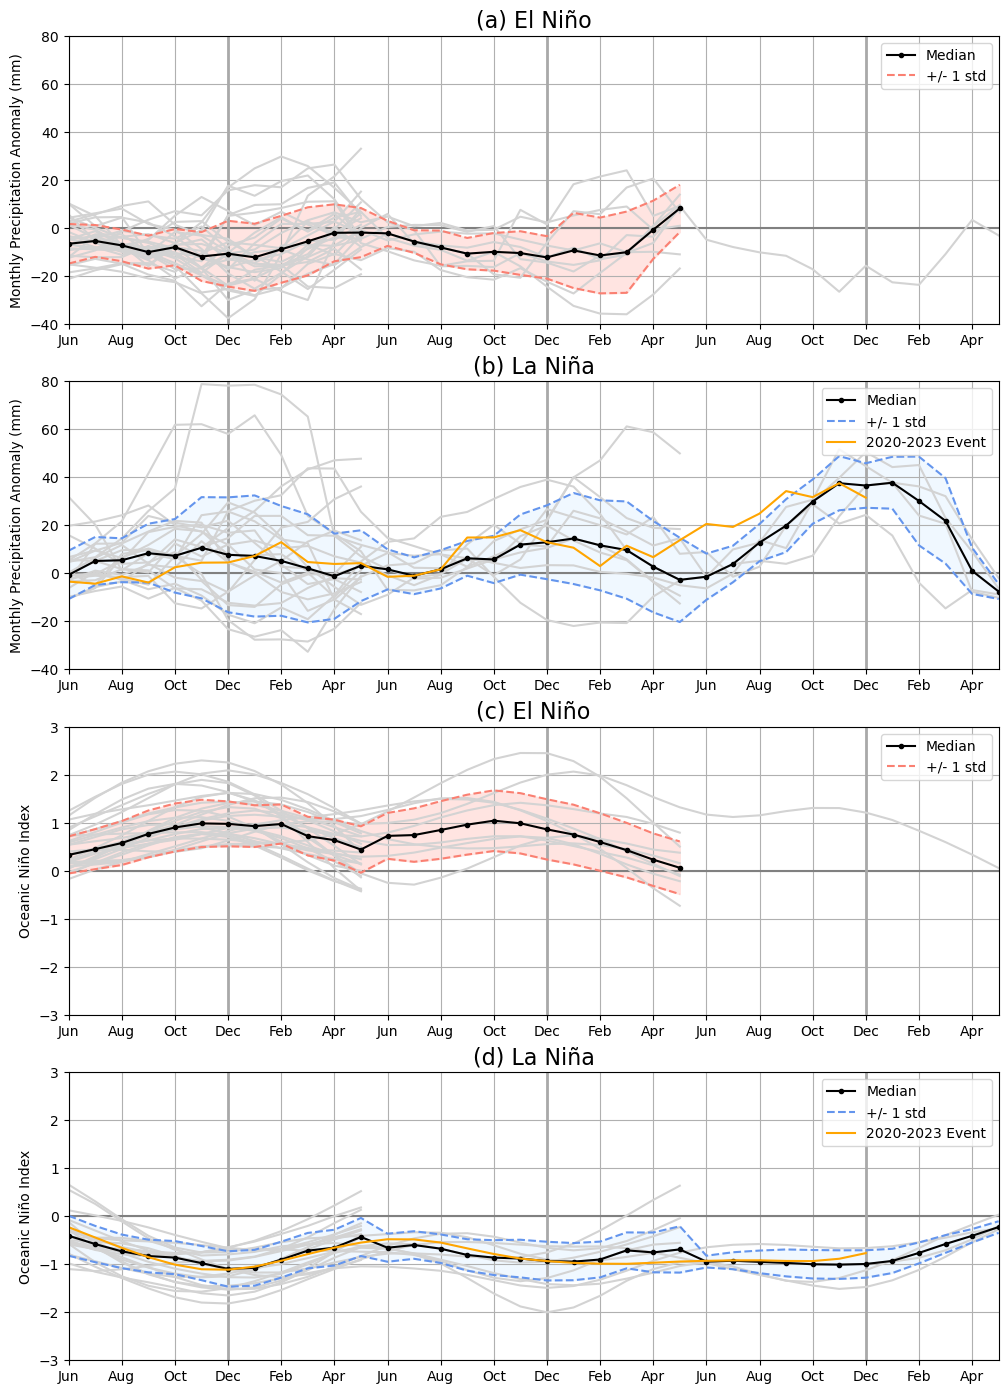

In [151]:
# Plot

# El Nino
plt.figure(figsize=[12,17.2])

plt.subplot(4,1,1)
plt.axhline(color='grey')
plt.axvline(6,color='darkgrey',linewidth=2)
plt.axvline(18,color='darkgrey',linewidth=2)
plt.axvline(30,color='darkgrey',linewidth=2)

for i in range(28):
    plt.plot(range(36),rolling_5[0,i,:],'lightgrey')

plt.plot(range(24),np.nanmedian(rolling_5[0,:,:24],axis=0),'k.-',label='Median')
plt.plot(range(24),np.nanmedian(rolling_5[0,:,:24],axis=0)+np.nanstd(rolling_5[0,:,:24],axis=0),'--',color='salmon',label='+/- 1 std')
plt.plot(range(24),np.nanmedian(rolling_5[0,:,:24],axis=0)-np.nanstd(rolling_5[0,:,:24],axis=0),'--',color='salmon')
plt.fill_between(range(24),np.nanmedian(rolling_5[0,:,:24],axis=0)+np.nanstd(rolling_5[0,:,:24],axis=0),np.nanmedian(rolling_5[0,:,:24],axis=0)-np.nanstd(rolling_5[0,:,:24],axis=0),color='mistyrose')

plt.xticks(range(0,36,2),year_3[::2])
plt.xlim((0,35))
plt.ylim((-40,80))
plt.ylabel('Monthly Precipitation Anomaly (mm)')
plt.title('(a) El Niño',fontsize=16)
plt.grid()
plt.legend()


#La Nina
plt.subplot(4,1,2)

plt.axhline(color='grey')
plt.axvline(6,color='darkgrey',linewidth=2)
plt.axvline(18,color='darkgrey',linewidth=2)
plt.axvline(30,color='darkgrey',linewidth=2)

for i in range(21):
    plt.plot(range(36),rolling_5[1,i,:],'lightgrey')

plt.plot(range(36),np.nanmedian(rolling_5[1,:,:],axis=0),'k.-',label='Median')
plt.plot(range(36),np.nanmedian(rolling_5[1,:,:],axis=0)+np.nanstd(rolling_5[1,:,:],axis=0),'--',color='cornflowerblue',label='+/- 1 std')
plt.plot(range(36),np.nanmedian(rolling_5[1,:,:],axis=0)-np.nanstd(rolling_5[1,:,:],axis=0),'--',color='cornflowerblue')
plt.fill_between(range(36),np.nanmedian(rolling_5[1,:,:],axis=0)+np.nanstd(rolling_5[1,:,:],axis=0),np.nanmedian(rolling_5[1,:,:],axis=0)-np.nanstd(rolling_5[1,:,:],axis=0),color='aliceblue')
plt.plot(range(36),rolling_5[1,22,:],'orange',label='2020-2023 Event')

plt.xticks(range(0,36,2),year_3[::2])
plt.xlim((0,35))
plt.ylim((-40,80))
plt.ylabel('Monthly Precipitation Anomaly (mm)')
plt.title('(b) La Niña',fontsize=16)
plt.grid()
plt.legend(loc='upper right')

plt.subplot(4,1,3)
plt.axhline(color='grey')
plt.axvline(6,color='darkgrey',linewidth=2)
plt.axvline(18,color='darkgrey',linewidth=2)
plt.axvline(30,color='darkgrey',linewidth=2)

for i in range(28):
    plt.plot(range(36),nino34_5[0,i,:],'lightgrey')

plt.plot(range(24),np.nanmedian(nino34_5[0,:,:24],axis=0),'k.-',label='Median')
plt.plot(range(24),np.nanmedian(nino34_5[0,:,:24],axis=0)+np.nanstd(nino34_5[0,:,:24],axis=0),'--',color='salmon',label='+/- 1 std')
plt.plot(range(24),np.nanmedian(nino34_5[0,:,:24],axis=0)-np.nanstd(nino34_5[0,:,:24],axis=0),'--',color='salmon')
plt.fill_between(range(24),np.nanmedian(nino34_5[0,:,:24],axis=0)+np.nanstd(nino34_5[0,:,:24],axis=0),np.nanmedian(nino34_5[0,:,:24],axis=0)-np.nanstd(nino34_5[0,:,:24],axis=0),color='mistyrose')

plt.xticks(range(0,36,2),year_3[::2])
plt.xlim((0,35))
plt.ylim((-3,3))
plt.ylabel('Oceanic Niño Index')
plt.title('(c) El Niño',fontsize=16)
plt.grid()
plt.legend()


#La Nina
plt.subplot(4,1,4)

# colormap = plt.cm.gist_ncar
# plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.coolwarm(np.linspace(0, 1, 22))))

plt.axhline(color='grey')
plt.axvline(6,color='darkgrey',linewidth=2)
plt.axvline(18,color='darkgrey',linewidth=2)
plt.axvline(30,color='darkgrey',linewidth=2)

for i in range(21):
    plt.plot(range(36),nino34_5[1,i,:],'lightgrey')

plt.plot(range(36),np.nanmedian(nino34_5[1,:,:],axis=0),'k.-',label='Median')
plt.plot(range(36),np.nanmedian(nino34_5[1,:,:],axis=0)+np.nanstd(nino34_5[1,:,:],axis=0),'--',color='cornflowerblue',label='+/- 1 std')
plt.plot(range(36),np.nanmedian(nino34_5[1,:,:],axis=0)-np.nanstd(nino34_5[1,:,:],axis=0),'--',color='cornflowerblue')
plt.fill_between(range(36),np.nanmedian(nino34_5[1,:,:],axis=0)+np.nanstd(nino34_5[1,:,:],axis=0),np.nanmedian(nino34_5[1,:,:],axis=0)-np.nanstd(nino34_5[1,:,:],axis=0),color='aliceblue')
plt.plot(range(36),nino34_5[1,22,:],'orange',label='2020-2023 Event')

plt.xticks(range(0,36,2),year_3[::2])
plt.xlim((0,35))
plt.ylim((-3,3))
plt.ylabel('Oceanic Niño Index')
plt.title('(d) La Niña',fontsize=16)
plt.grid()
plt.legend(loc='upper right')

plt.savefig('/home/156/ah3693/CLEX_summer/Fig3_Evolution_of_Rainfall.eps', format='eps',bbox_inches="tight",dpi=700)

plt.show()

In [152]:
print('El Nino',np.nanmedian(rolling_5[0,:,:24],axis=0))
print('La Nina',np.nanmedian(rolling_5[1,:,:],axis=0))

El Nino [ -6.65038772  -5.4722673   -7.32269556 -10.13180275  -8.07189943
 -11.9549064  -10.77684677 -12.2909571   -8.95387928  -5.63495492
  -2.07498213  -1.98968668  -2.30988448  -5.71743625  -8.18170971
 -10.75793129 -10.00129557 -10.51848688 -12.32869177  -9.42078018
 -11.52669148 -10.15940224  -0.81524022   8.0953727 ]
La Nina [-0.63830635  5.13997571  5.44738139  8.39836875  7.28938599 10.65604738
  7.71805857  7.21670867  5.1824192   2.06977564 -1.21581948  3.17415689
  1.64323837 -1.01315102  1.66534231  6.2533846   5.78081537 11.97529523
 12.94661301 14.51189119 11.66381628  9.68789713  2.77548824 -2.73025075
 -1.42362817  3.88305472 12.7956222  19.87058355 29.89587422 37.56158947
 36.59159696 37.75828501 30.1584357  21.86322497  1.05174495 -7.59085924]


In [164]:
print(elnino_year)
print(lanina_year)

[1902 1904 1905 1911 1913 1914 1918 1919 1923 1925 1930 1939 1940 1941
 1951 1953 1957 1958 1963 1965 1968 1969 1972 1976 1977 1979 1982 1986
 1987 1991 1994 1997 2002 2004 2006 2009 2014 2015 2018]
[1903 1906 1908 1909 1910 1915 1916 1917 1922 1924 1933 1938 1942 1949
 1954 1955 1964 1970 1971 1973 1974 1975 1983 1984 1988 1995 1998 1999
 2000 2005 2007 2008 2010 2011 2016 2017 2020 2021 2022]


In [207]:
EN_slope,EN_int = np.polyfit(nino34_ndj.sel(time=nino34_ndj.time.dt.year.isin([elnino_year])),rolling_3_SON.sel(time=rolling_3_SON.time.dt.year.isin([elnino_year])),1)
EN_oni = np.linspace(0,3,10)
LN_slope,LN_int = np.polyfit(nino34_ndj.sel(time=nino34_ndj.time.dt.year.isin([lanina_year])),rolling_3_SON.sel(time=rolling_3_SON.time.dt.year.isin([lanina_year])),1)
LN_oni = np.linspace(-3,0,10)

In [167]:
np.corrcoef(nino34_ndj.sel(time=nino34_ndj.time.dt.year.isin([elnino_year])),rolling_3_SON.sel(time=rolling_3_SON.time.dt.year.isin([elnino_year])))

array([[ 1.        , -0.17900954],
       [-0.17900954,  1.        ]])

In [168]:
np.corrcoef(nino34_ndj.sel(time=nino34_ndj.time.dt.year.isin([lanina_year])),rolling_3_SON.sel(time=rolling_3_SON.time.dt.year.isin([lanina_year])))

array([[ 1.        , -0.19107693],
       [-0.19107693,  1.        ]])

In [169]:
EN_nino34_ndj = nino34_ndj.where(nino34_ndj>0).dropna(dim='time')
EN_precip_SON = rolling_3_SON.sel(time=rolling_3_SON.time.dt.year.isin(EN_nino34_ndj.time.dt.year))

LN_nino34_ndj = nino34_ndj.where(nino34_ndj<0).dropna(dim='time')
LN_precip_SON = rolling_3_SON.sel(time=rolling_3_SON.time.dt.year.isin(LN_nino34_ndj.time.dt.year))

EN_slope_n,EN_int_n = np.polyfit(EN_nino34_ndj,EN_precip_SON,1)
LN_slope_n,LN_int_n = np.polyfit(LN_nino34_ndj,LN_precip_SON,1)

In [170]:
import scipy.stats as stats
stats.pearsonr(EN_nino34_ndj,EN_precip_SON)

PearsonRResult(statistic=-0.27713094428983454, pvalue=0.046702732797175094)

In [171]:
stats.pearsonr(LN_nino34_ndj,LN_precip_SON)

PearsonRResult(statistic=-0.4635303160799686, pvalue=4.6822764464198155e-05)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


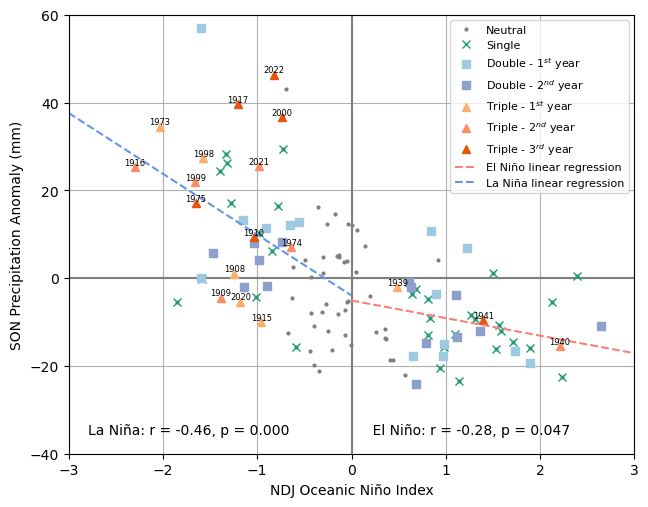

In [172]:
plt.figure(figsize=(7.3,5.7))
plt.axhline(color='grey')
plt.axvline(color='grey')
# Single event, double event, triple event
sdt_elnino_s = [1902, 1911, 1923, 1925, 1930, 1951, 1953, 1963, 1965, 1972, 1979, 1982, 1991, 1994, 1997, 2002, 2004, 2006, 2009, 2018]
sdt_elnino_d1 = [1904, 1913, 1918, 1957, 1968, 1976, 1986, 2014]
sdt_elnino_d2 = [1905, 1914, 1919, 1958, 1969, 1977, 1987, 2015]
sdt_lanina_s = [1903, 1906, 1922, 1924, 1933, 1938, 1942, 1949, 1964, 1988, 1995, 2005]
sdt_lanina_d1 = [1954, 1970, 1983, 2007, 2010, 2016]
sdt_lanina_d2 = [1955, 1971, 1984, 2008, 2011, 2017]
sdt_lanina_t1 = [1908, 1915, 1939, 1973, 1998, 2020]
sdt_lanina_t2 = [1909, 1916, 1940, 1974, 1999, 2021]
sdt_lanina_t3 = [1910, 1917, 1941, 1975, 2000, 2022]

rolling_3_SON = affect_region_rolling_3.sel(time=affect_region_rolling_3.time.dt.month.isin([10]))

plt.plot(nino34_ndj,rolling_3_SON,'.',color='grey',markersize=4,label='Neutral')
plt.plot(nino34_ndj.sel(time=nino34_ndj.time.dt.year.isin([sdt_elnino_s])),rolling_3_SON.sel(time=rolling_3_SON.time.dt.year.isin([sdt_elnino_s])),'x',color='#1b9e77',label='Single')
plt.plot(nino34_ndj.sel(time=nino34_ndj.time.dt.year.isin([sdt_elnino_d1])),rolling_3_SON.sel(time=rolling_3_SON.time.dt.year.isin([sdt_elnino_d1])),'s',color='#9ecae1',label='Double - 1$^{st}$ year')
plt.plot(nino34_ndj.sel(time=nino34_ndj.time.dt.year.isin([sdt_elnino_d2])),rolling_3_SON.sel(time=rolling_3_SON.time.dt.year.isin([sdt_elnino_d2])),'s',color='#8da0cb',label='Double - 2$^{nd}$ year')
plt.plot(nino34_ndj.sel(time=nino34_ndj.time.dt.year.isin([sdt_lanina_s])),rolling_3_SON.sel(time=rolling_3_SON.time.dt.year.isin([sdt_lanina_s])),'x',color='#1b9e77')
plt.plot(nino34_ndj.sel(time=nino34_ndj.time.dt.year.isin([sdt_lanina_d1])),rolling_3_SON.sel(time=rolling_3_SON.time.dt.year.isin([sdt_lanina_d1])),'s',color='#9ecae1')
plt.plot(nino34_ndj.sel(time=nino34_ndj.time.dt.year.isin([sdt_lanina_d2])),rolling_3_SON.sel(time=rolling_3_SON.time.dt.year.isin([sdt_lanina_d2])),'s',color='#8da0cb')
plt.plot(nino34_ndj.sel(time=nino34_ndj.time.dt.year.isin([sdt_lanina_t1])),rolling_3_SON.sel(time=rolling_3_SON.time.dt.year.isin([sdt_lanina_t1])),'^',color='#fdae6b',label='Triple - 1$^{st}$ year')
plt.plot(nino34_ndj.sel(time=nino34_ndj.time.dt.year.isin([sdt_lanina_t2])),rolling_3_SON.sel(time=rolling_3_SON.time.dt.year.isin([sdt_lanina_t2])),'^',color='#fc8d62',label='Triple - 2$^{nd}$ year')
plt.plot(nino34_ndj.sel(time=nino34_ndj.time.dt.year.isin([sdt_lanina_t3])),rolling_3_SON.sel(time=rolling_3_SON.time.dt.year.isin([sdt_lanina_t3])),'^',color='#e6550d',label='Triple - 3$^{rd}$ year')
# plt.plot(EN_oni,EN_oni*EN_slope+EN_int,'--',color='salmon',label='El Nino linear regression')
# plt.plot(LN_oni,LN_oni*LN_slope+LN_int,'--',color='cornflowerblue',label='La Nina linear regression')
plt.plot(EN_oni,EN_oni*EN_slope_n+EN_int_n,'--',color='salmon',label='El Niño linear regression')
plt.plot(LN_oni,LN_oni*LN_slope_n+LN_int_n,'--',color='cornflowerblue',label='La Niña linear regression')

for year in range(6):
    plt.text(nino34_ndj.sel(time=nino34_ndj.time.dt.year.isin([sdt_lanina_t1]))[year], rolling_3_SON.sel(time=rolling_3_SON.time.dt.year.isin([sdt_lanina_t1]))[year], [str(i) for i in sdt_lanina_t1][year], ha='center', va='bottom',fontsize=6)
    plt.text(nino34_ndj.sel(time=nino34_ndj.time.dt.year.isin([sdt_lanina_t2]))[year], rolling_3_SON.sel(time=rolling_3_SON.time.dt.year.isin([sdt_lanina_t2]))[year], [str(i) for i in sdt_lanina_t2][year], ha='center', va='bottom',fontsize=6)
    plt.text(nino34_ndj.sel(time=nino34_ndj.time.dt.year.isin([sdt_lanina_t3]))[year], rolling_3_SON.sel(time=rolling_3_SON.time.dt.year.isin([sdt_lanina_t3]))[year], [str(i) for i in sdt_lanina_t3][year], ha='center', va='bottom',fontsize=6)


plt.xlim((-3,3))
plt.ylim((-40,60))
plt.xlabel('NDJ Oceanic Niño Index')
plt.ylabel('SON Precipitation Anomaly (mm)')
plt.legend(fontsize=8)
plt.grid()

# plt.text(-2.8,-31,'El Niño: r = -0.24, p = 0.09')
plt.text(-2.8,-35.5,'La Niña: r = -0.46, p = 0.000                   El Niño: r = -0.28, p = 0.047')

plt.savefig('/home/156/ah3693/CLEX_summer/Fig2_Asymmetry_in_teleconnection.eps', format='eps',bbox_inches="tight",dpi=700)

plt.show()

In [174]:
stats.pearsonr(EN_nino34_ndj.sel(time=slice('19110101','20231231')),EN_soil_SON)

PearsonRResult(statistic=-0.41016705576507523, pvalue=0.003786693566202326)

In [175]:
stats.pearsonr(LN_nino34_ndj.sel(time=slice('19110101','20231231')),LN_soil_SON)

PearsonRResult(statistic=-0.4746940722474939, pvalue=7.400267086105924e-05)

In [187]:
rolling_5_r3 = affect_region_rolling_5.rolling(time=3,center=True).mean()
rolling_5_r3 = rolling_5_r3.fillna(affect_region_rolling_5[0])
rolling_5_r3[-1] = affect_region_rolling_5[-1]
rolling_5_r3_ndj = rolling_5_r3.sel(time=rolling_5_r3.time.dt.month.isin([12]))
# rolling_5_r3_ndj = affect_region_rolling_5.sel(time=affect_region_rolling_5.time.dt.month.isin([12]))

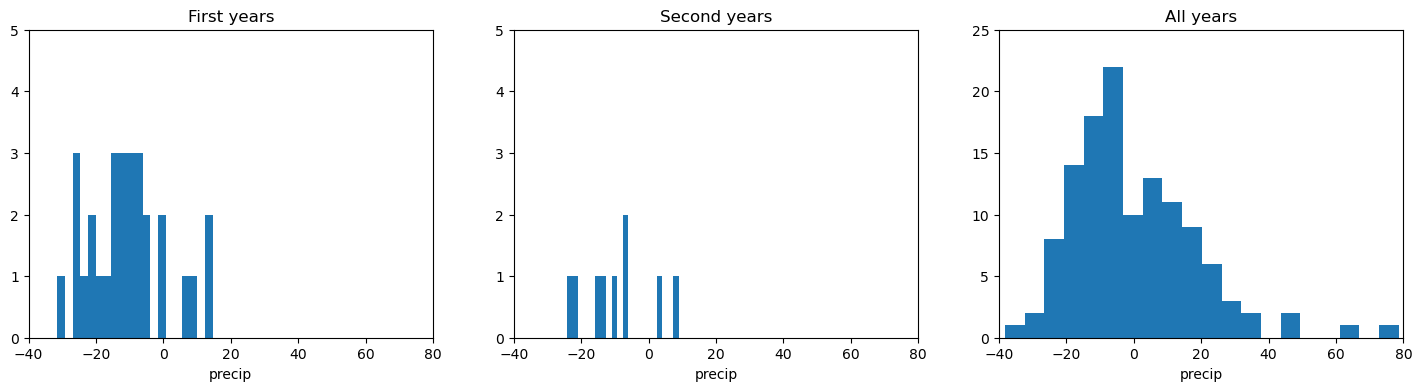

In [188]:
EN_f_ndj = rolling_5_r3_ndj.sel(time=rolling_5_r3_ndj.time.dt.year.isin([fst_elnino_f]))
EN_s_ndj = rolling_5_r3_ndj.sel(time=rolling_5_r3_ndj.time.dt.year.isin([fst_elnino_s]))

plt.figure(figsize=(24,4))
plt.subplot(141)
EN_f_ndj.plot.hist(bins=20,xlim=(-40,80),ylim=(0,5))
plt.title('First years')
plt.subplot(142)
EN_s_ndj.plot.hist(bins=20,xlim=(-40,80),ylim=(0,5))
plt.title('Second years')
plt.subplot(143)
rolling_5_r3_ndj.plot.hist(bins=20,xlim=(-40,80),ylim=(0,25))
plt.title('All years')
plt.show()

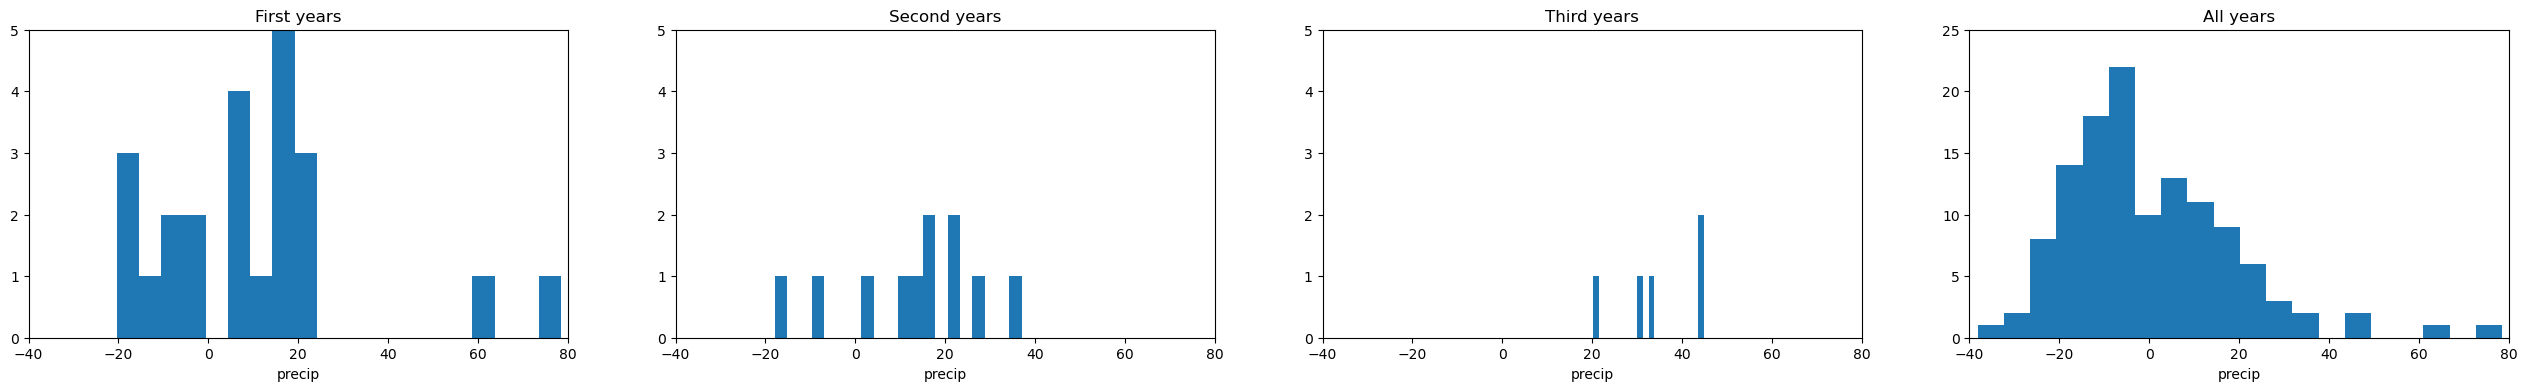

In [189]:
LN_f_ndj = rolling_5_r3_ndj.sel(time=rolling_5_r3_ndj.time.dt.year.isin([fst_lanina_f]))
LN_s_ndj = rolling_5_r3_ndj.sel(time=rolling_5_r3_ndj.time.dt.year.isin([fst_lanina_s]))
LN_t_ndj = rolling_5_r3_ndj.sel(time=rolling_5_r3_ndj.time.dt.year.isin([fst_lanina_t]))
plt.figure(figsize=(32,4))
plt.subplot(141)
LN_f_ndj.plot.hist(bins=20,xlim=(-40,80),ylim=(0,5))
plt.title('First years')
plt.subplot(142)
LN_s_ndj.plot.hist(bins=20,xlim=(-40,80),ylim=(0,5))
plt.title('Second years')
plt.subplot(143)
LN_t_ndj.plot.hist(bins=20,xlim=(-40,80),ylim=(0,5))
plt.title('Third years')
plt.subplot(144)
rolling_5_r3_ndj.plot.hist(bins=20,xlim=(-40,80),ylim=(0,25))
plt.title('All years')
plt.show()

In [190]:
from scipy.stats import ttest_ind
ttest_ind(LN_f_ndj,rolling_5_r3_ndj)

TtestResult(statistic=2.41774189139228, pvalue=0.016867073622409332, df=144.0)

In [191]:
ttest_ind(LN_s_ndj,rolling_5_r3_ndj)

TtestResult(statistic=2.248762918172671, pvalue=0.026184846396843243, df=132.0)

In [192]:
ttest_ind(LN_t_ndj,rolling_5_r3_ndj)

TtestResult(statistic=4.167579218045231, pvalue=5.67652472303473e-05, df=126.0)

In [193]:
ttest_ind(EN_f_ndj,rolling_5_r3_ndj)

TtestResult(statistic=-2.9036821175252516, pvalue=0.004245391636711223, df=150.0)

In [194]:
ttest_ind(EN_s_ndj,rolling_5_r3_ndj)

TtestResult(statistic=-1.539100170833285, pvalue=0.1262103845061887, df=130.0)

In [195]:
ttest_ind(LN_f_ndj,LN_s_ndj)

TtestResult(statistic=-0.2992151970175974, pvalue=0.7667106237678484, df=32.0)

In [196]:
ttest_ind(LN_f_ndj,LN_t_ndj)

TtestResult(statistic=-2.2369262094620415, pvalue=0.0340832925933765, df=26.0)

In [197]:
ttest_ind(LN_s_ndj,LN_t_ndj)

TtestResult(statistic=-2.8280371420231765, pvalue=0.013418551451623474, df=14.0)

In [198]:
ttest_ind(EN_f_ndj,EN_s_ndj)

TtestResult(statistic=-0.1851624310149547, pvalue=0.8541409021693589, df=36.0)

In [199]:
np.std(LN_f_ndj)

<xarray.DataArray 'precip' ()>
array(22.80017396)

In [200]:
np.std(LN_t_ndj)

<xarray.DataArray 'precip' ()>
array(9.24750285)

In [201]:
Sp = (((len(LN_s_ndj)-1)*(np.std(LN_s_ndj)**2)+(len(LN_t_ndj)-1)*(np.std(LN_t_ndj)**2))/(len(LN_s_ndj)+len(LN_t_ndj)-2))**(1/2)

In [202]:
(len(LN_s_ndj)+len(LN_t_ndj)-2)

14

In [203]:
LN_f_ndj

<xarray.DataArray 'precip' (time: 23)>
array([ 10.94236858,   8.56221076, -10.79430436, -15.76047716,
       -20.3593217 ,  18.33322558,  17.91705033,  -7.71649629,
         6.87000121,  18.52094871,  20.48427401, -15.81318536,
        16.52867667,  78.56067722,  23.89406135,  -1.67230922,
         6.22623431,  14.3084432 , -10.14655173,  23.75170685,
        62.03089769,  -4.58946788,   5.38786516])
Coordinates:
  * time     (time) datetime64[ns] 1903-12-16 1906-12-16 ... 2020-12-16

fig = plt.figure(figsize=[10,5])
ax = fig.add_subplot(111,projection=ccrs.PlateCarree())
sst['SST_cpl'].sel(time='19010116').plot(ax=ax,cmap='jet',transform=ccrs.PlateCarree())
ax.coastlines()
plt.show()

sst_data = nc.Dataset('/scratch/w97/ast561/SSTClim.EasternPacificENSO.nc','r')
sst = sst_data.variables['SST_cpl'][:,:,:] #dimension: time,lat,lon

lat = sst_data.variables['lat'][:]
lon = sst_data.variables['lon'][:]
time = sst_data.variables['time'][:]
print(sst_data.variables['time'].units)
sst_data.close()